In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import glob
import pickle
import matplotlib.pyplot as plt

from interpretation.interpret import compute_importance_score_c_type, compute_importance_score_bias, visualize_sequence_imp
from models.models import CATAC2, CATAC_w_bias

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Representation first filter

In [3]:
#Load test set sequences
chr_include = ['6','13','22'] 

with open('../results/peaks_seq.pkl', 'rb') as file:
    seq = pickle.load(file)

seq = seq[seq.chr.isin(chr_include)].sequence
seq

peakID
6:13041006-13042038       AGCCAAGATTGATATTTGATTAGCTCTGCAGTAAAGTTCCCATCAA...
22:42954423-42955138      GCTCACTACAATCTCTGCCTCCCAGGTTCAAGCAATTCTCCTGCCT...
13:61316358-61317296      AACTGAAAGAAACTAAAAAGCTTTACACTTTCTATAATCTTCTGCA...
13:73450511-73451395      CGTCAAGTAGATGAATAATTGTTGACAAGGAAAAATGTTTTTATCT...
13:72625660-72626633      ATCACTATTATAACTCTTGGCTTTAGACTTTAGTCACTGAAACTTG...
                                                ...                        
13:33179471-33180328      GGAAGGAAGGAAGGAAGGAAGGAAAGGAAGGAAGGAAGGAAGGAAG...
6:106997359-106998408     TGTTTACGCTGTACTTATGAAGGTGTGAAGGCTCAGAGCAGGGACA...
6:24270202-24271280       CCCAAGTAGCTGAGACTACAGGCATGCGACACTATGCCCGGCTAAT...
13:101144429-101145480    CAATGCATAGAGTAAAAAATGTTAGGTTTCATGATATCTTTTACAA...
6:1685782-1686834         GGGAATGCAACAGGGCAGAGCGGTTGTGGAAAACAGCCTGAGCCTG...
Name: sequence, Length: 1000, dtype: object

In [4]:
from data_processing.utils_data_preprocessing import one_hot_encode

path_model = '../results/train_res/128_model.pkl'
all_c_type = ['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite']

#Load the model
model = CATAC_w_bias(nb_conv=8, nb_filters=128, first_kernel=21, 
                      rest_kernel=3, out_pred_len=1024, 
                      nb_pred=4)
        
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))

#On-hot encode the sequences
seq_enc = seq.apply(lambda x: one_hot_encode(x))

#Add cell type encoding
c_type = "Myogenic"
mapping = dict(zip(all_c_type, range(len(all_c_type))))    
c_type = mapping[c_type]
c_type = torch.from_numpy(np.eye(len(all_c_type), dtype=np.float32)[c_type])

#Repeat and reshape
c_type = c_type.tile((seq_enc[0].shape[0],1))
seq_enc = [np.concatenate((s,c_type), axis=1) for s in seq_enc]
seq_enc = torch.tensor(seq_enc).permute(0,2,1)


/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_45076/695990019.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c_type = c_type.tile((seq_enc[0].shape[0],1))
/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_45076/695990019.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_f904_uudri/croot/pytorch-select_1707783714699/work/torch/csrc/utils/tensor_new.cpp:278.)
  seq_enc = torch.tensor(seq_enc).permute(0,2,1)


In [5]:
#Pass each sequences through first convolution
first_conv = model.first_filter_output(seq_enc)

In [6]:
#Determine max activation for each filter
max_activations = []
for i in range(first_conv.size(1)):
    max_activations.append(first_conv[:,i,:].max().item())

/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_45076/2937902614.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  subseq.append(seq[j][(idx-10):(idx+20)])


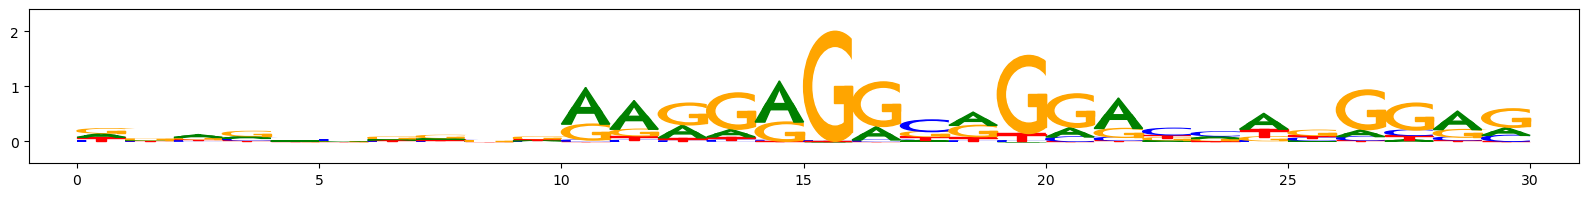

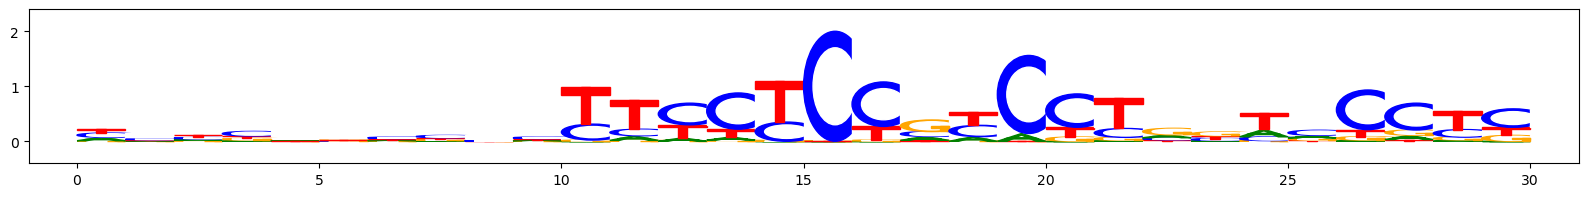

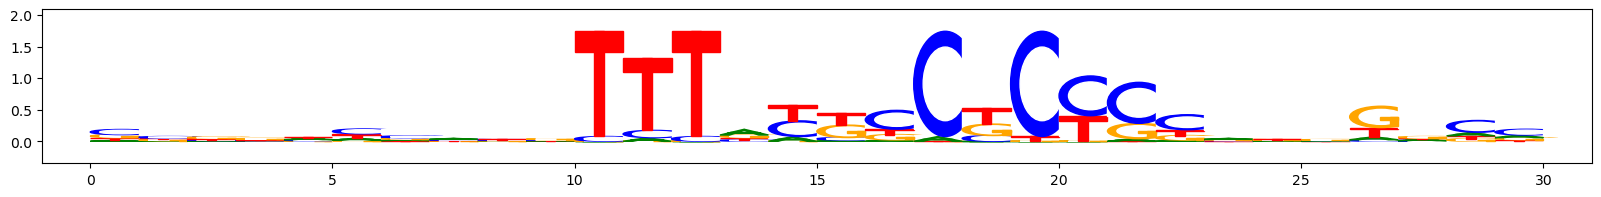

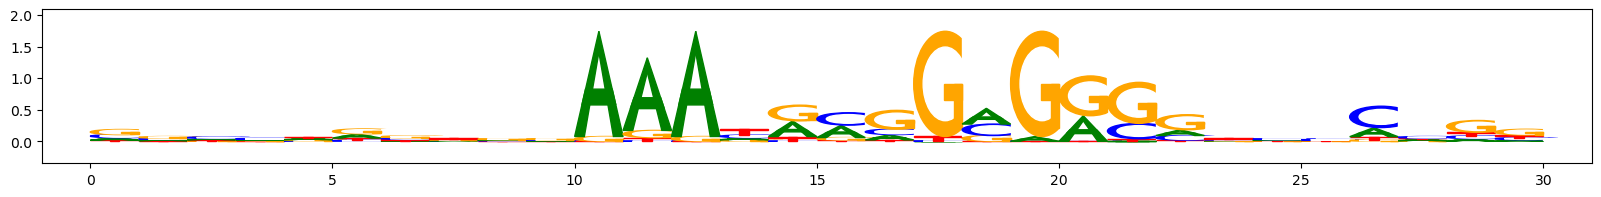

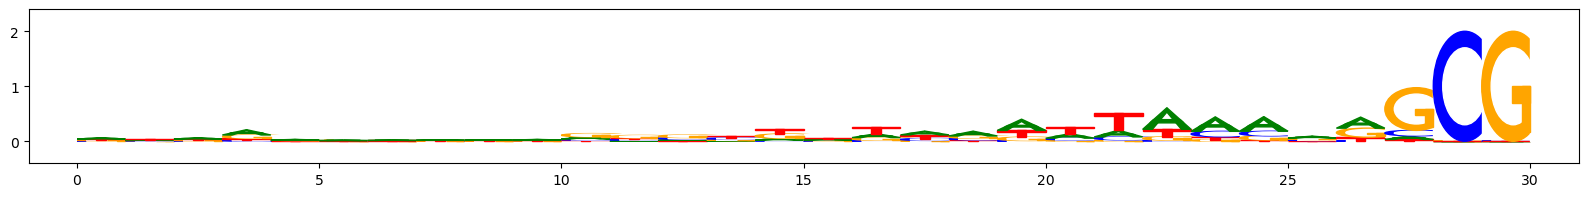

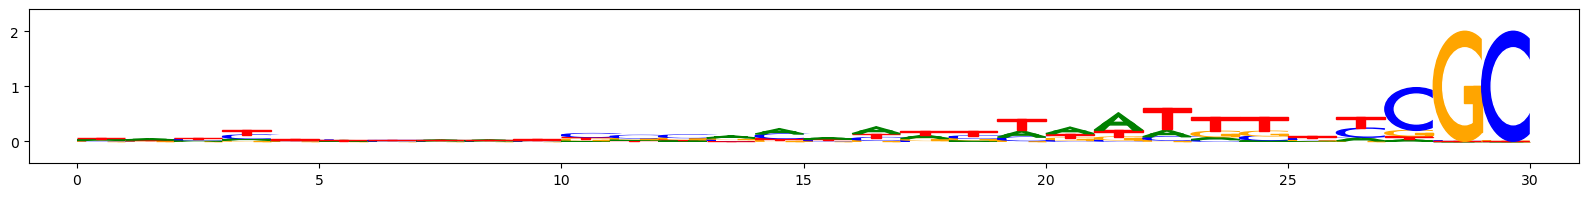

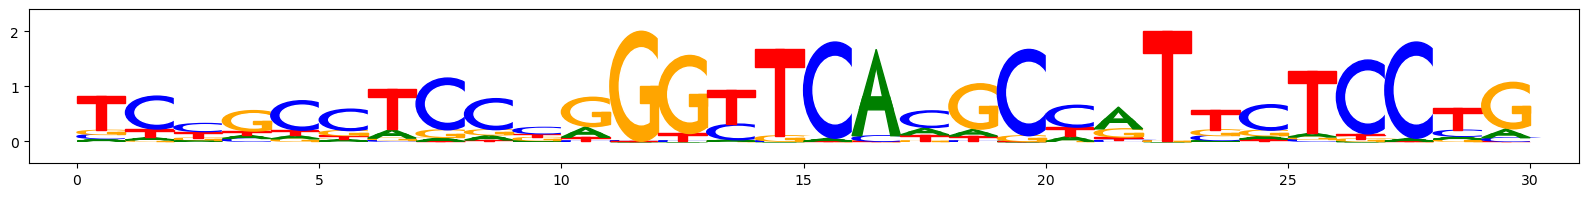

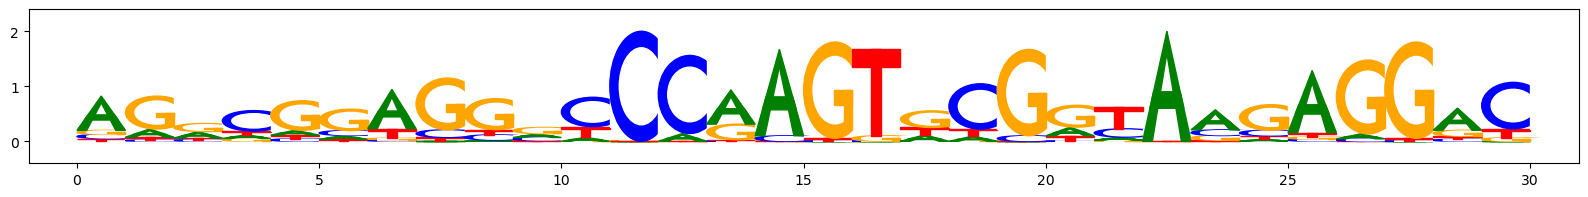

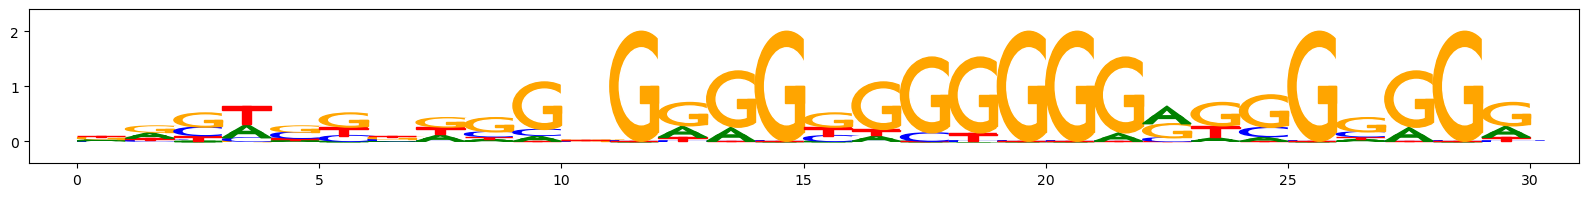

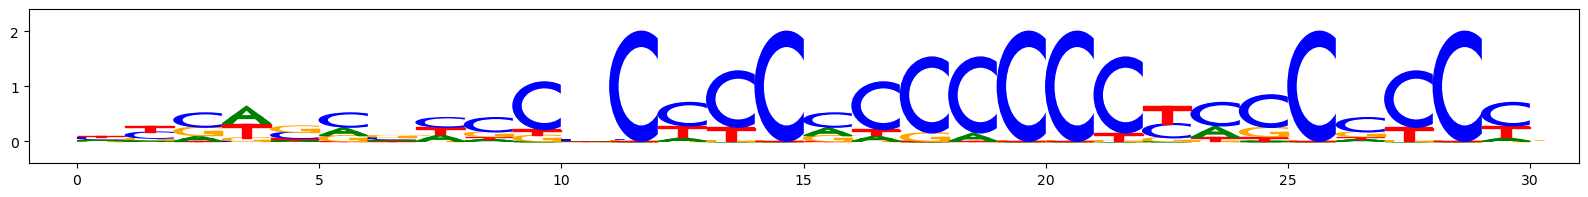

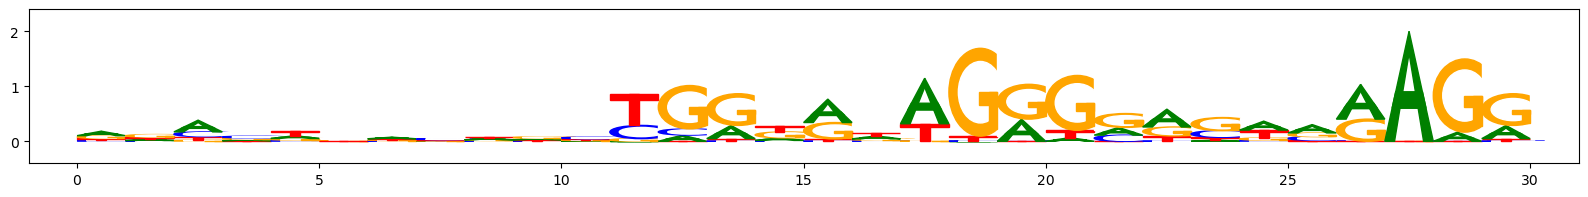

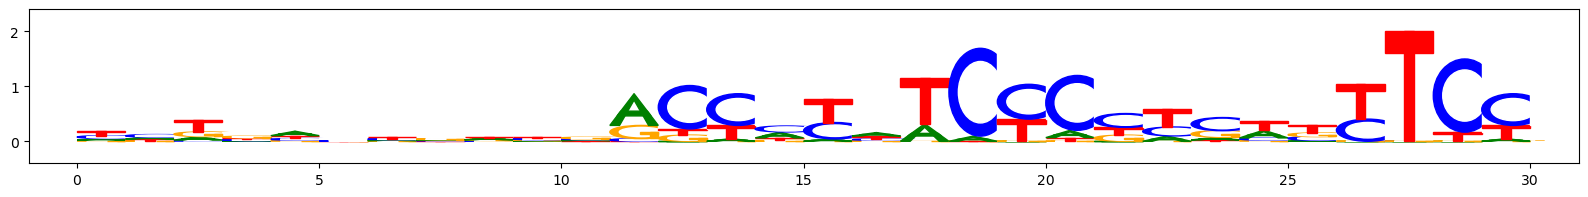

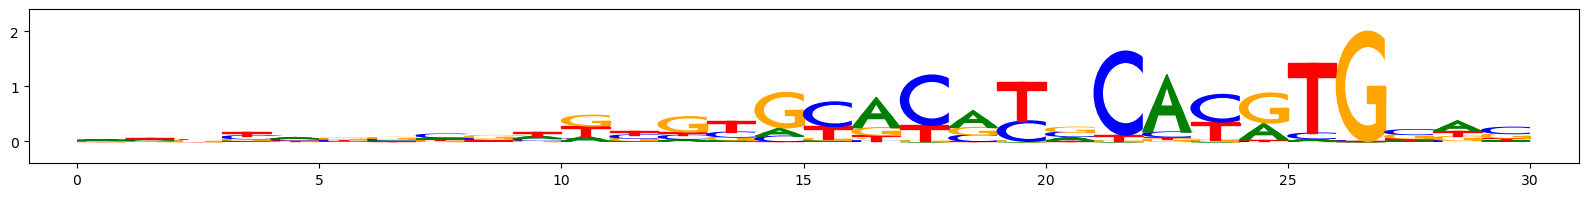

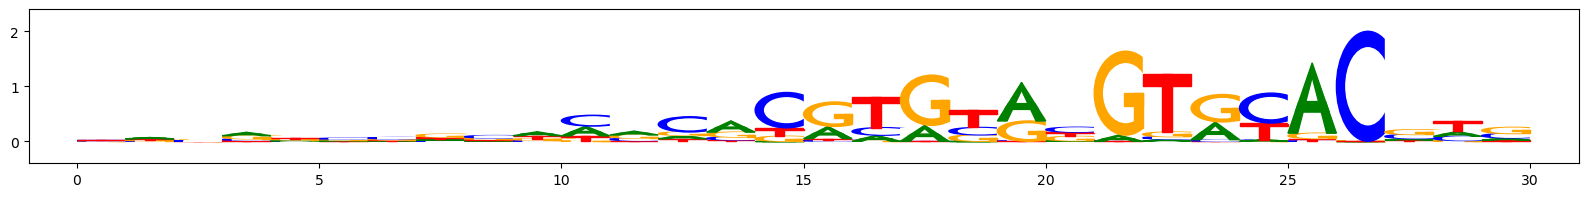

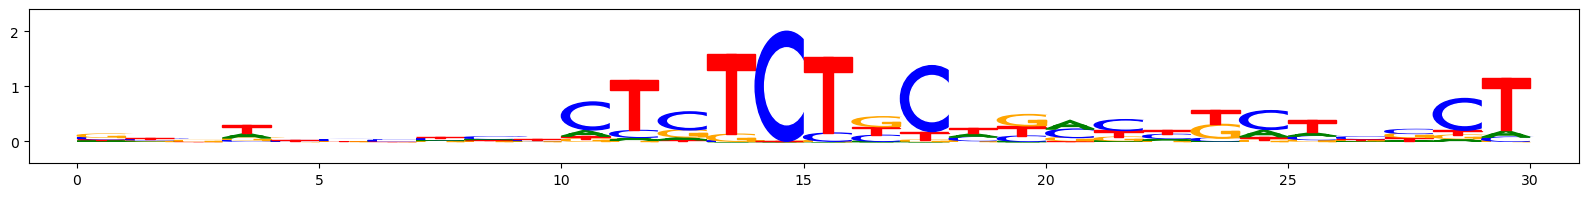

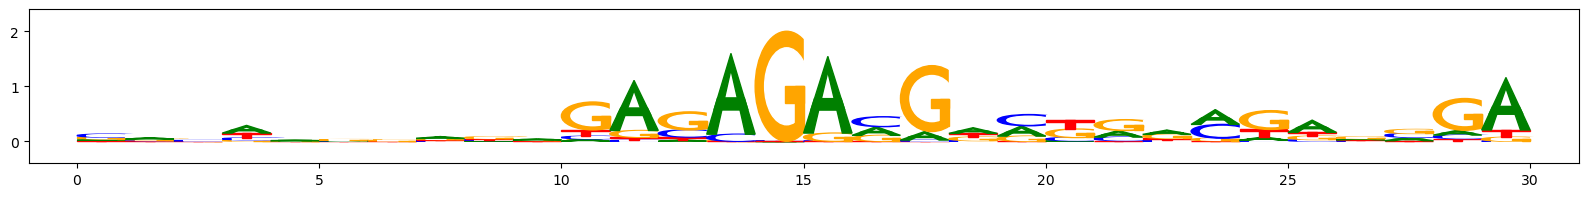

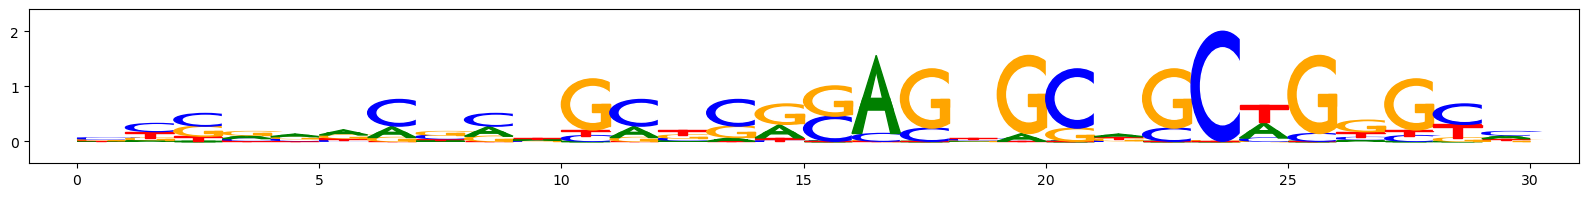

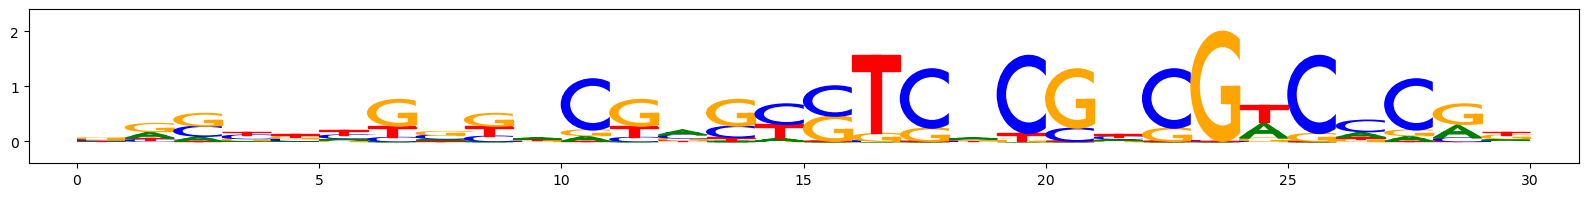

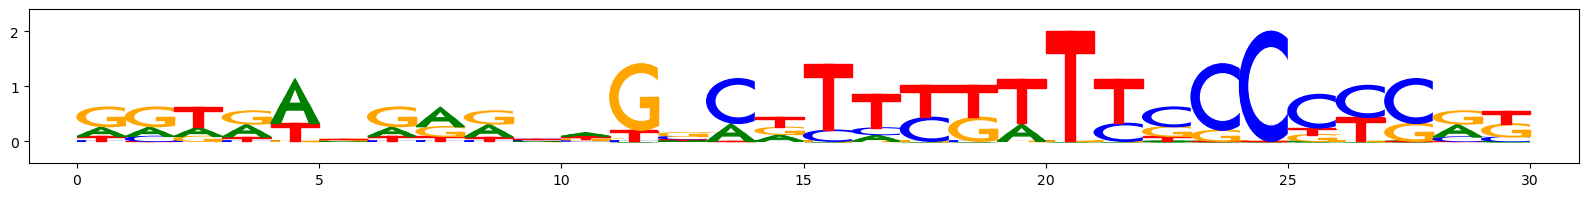

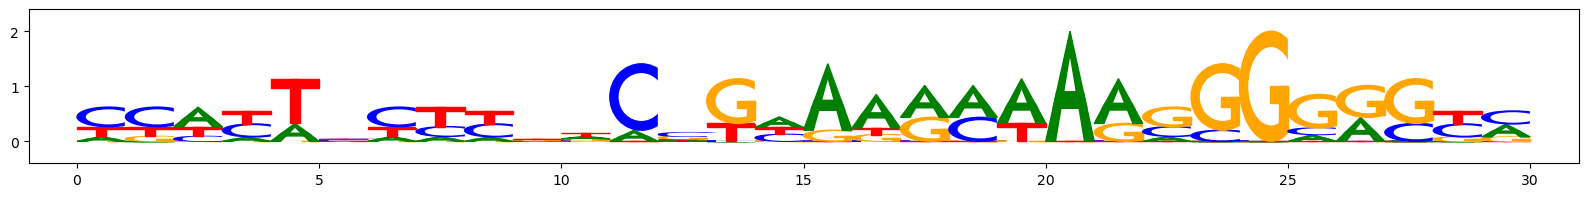

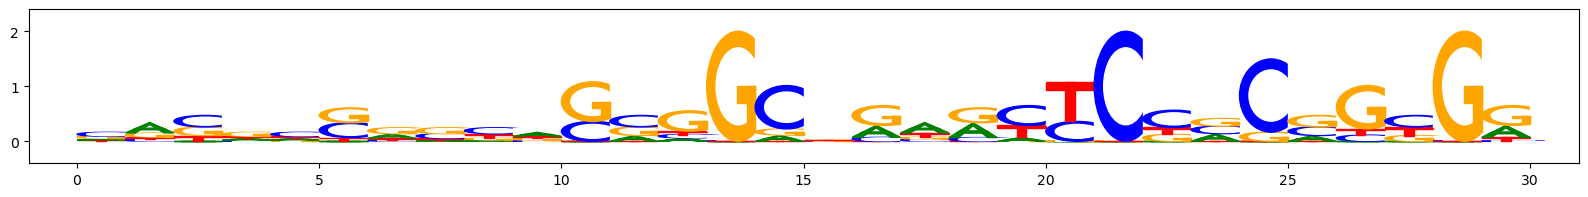

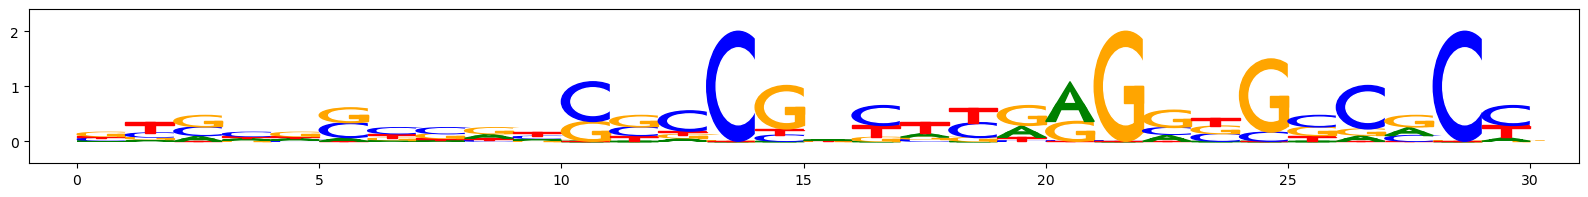

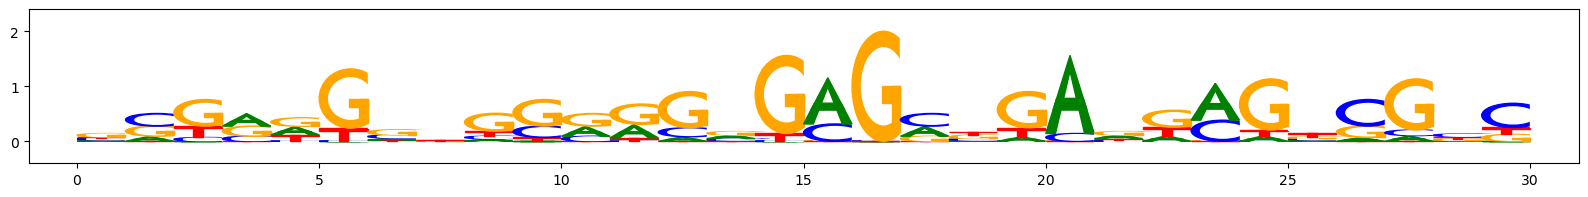

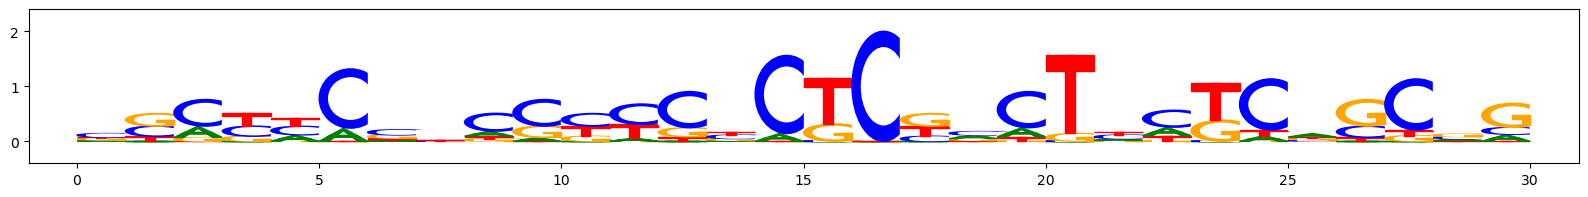

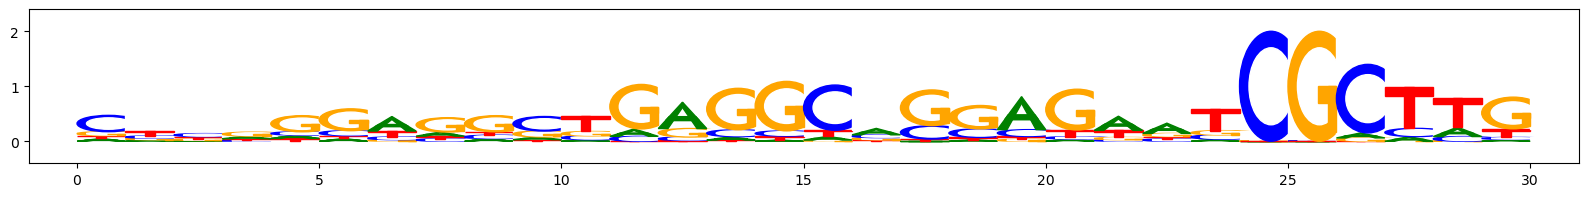

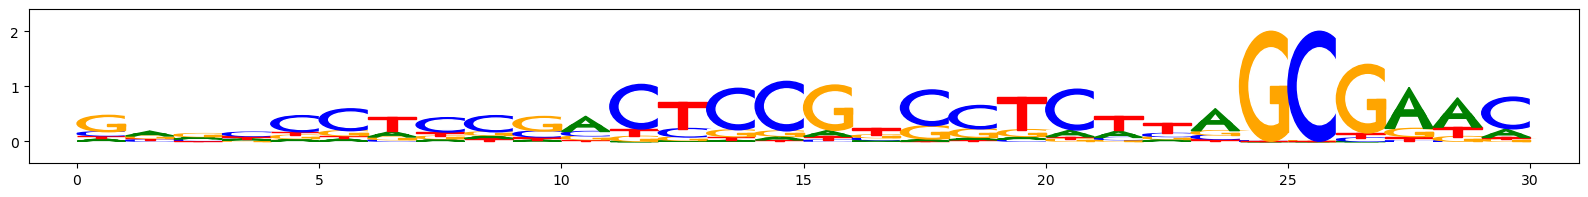

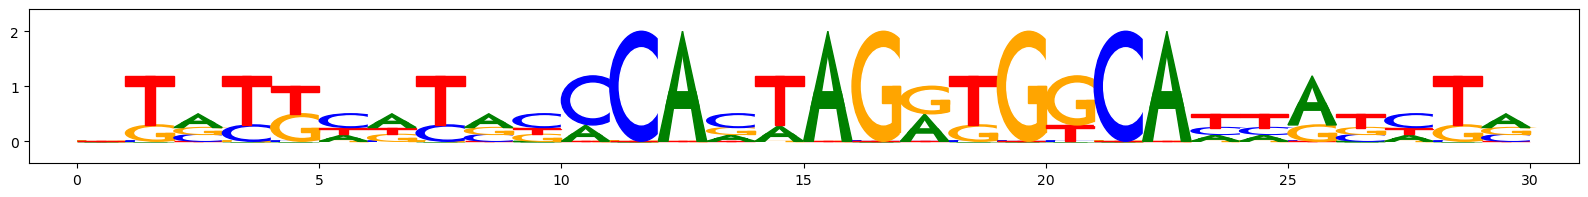

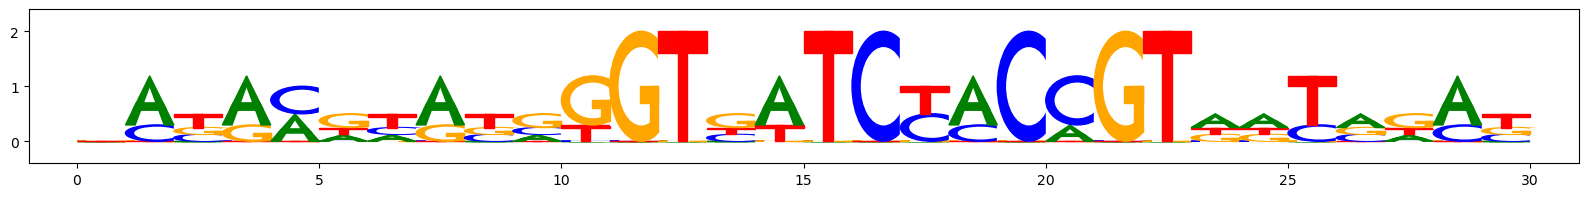

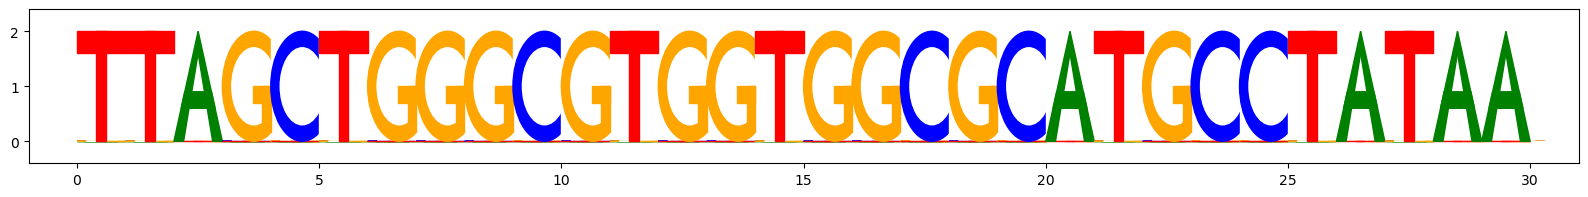

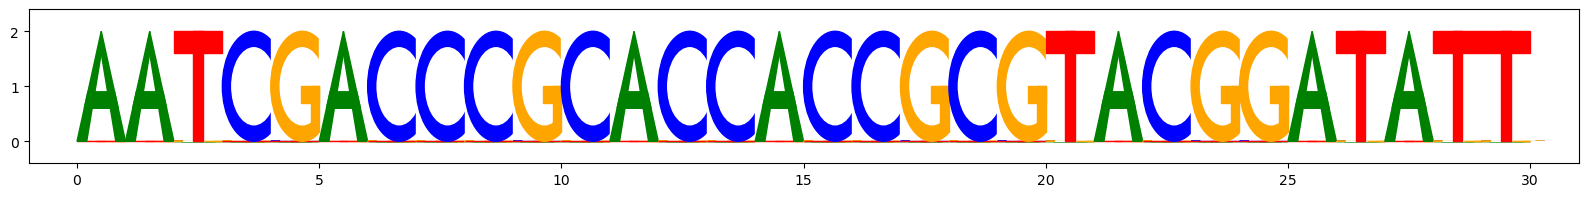

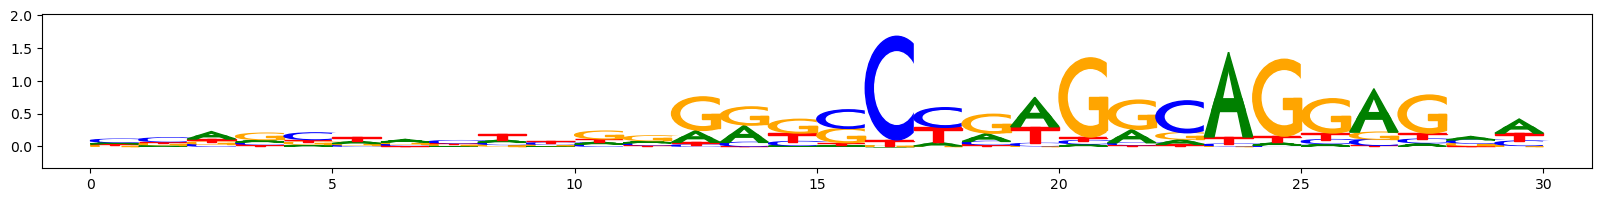

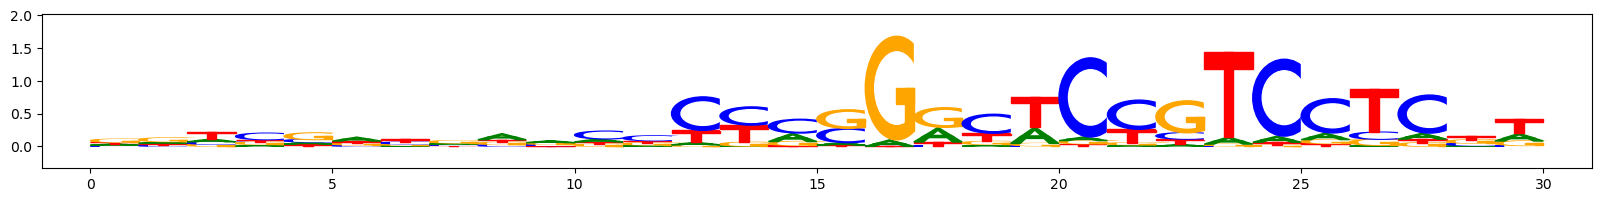

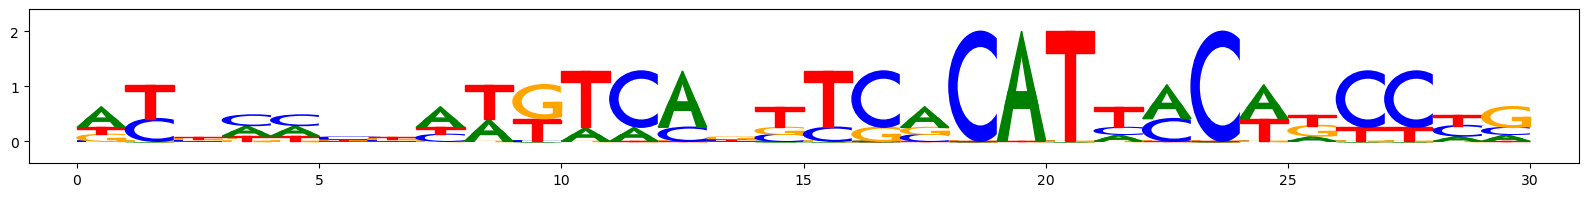

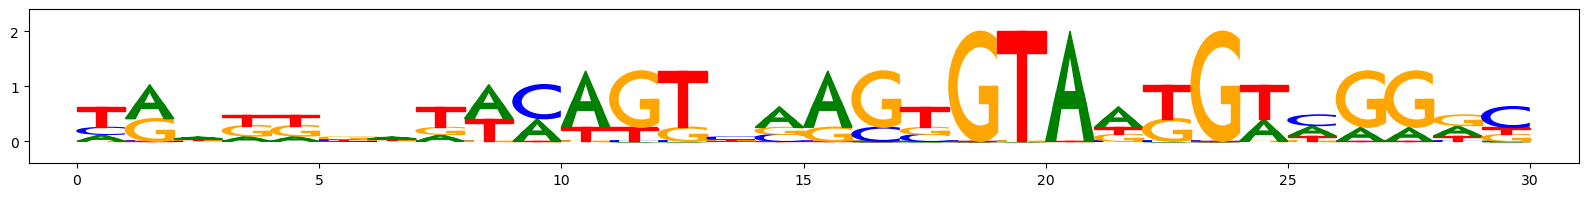

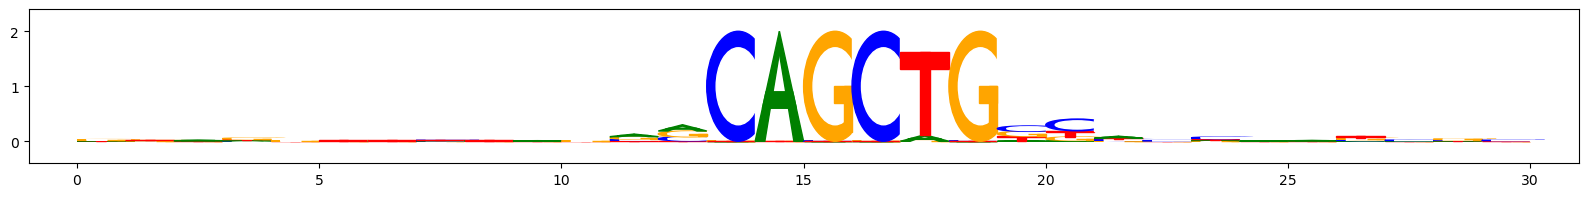

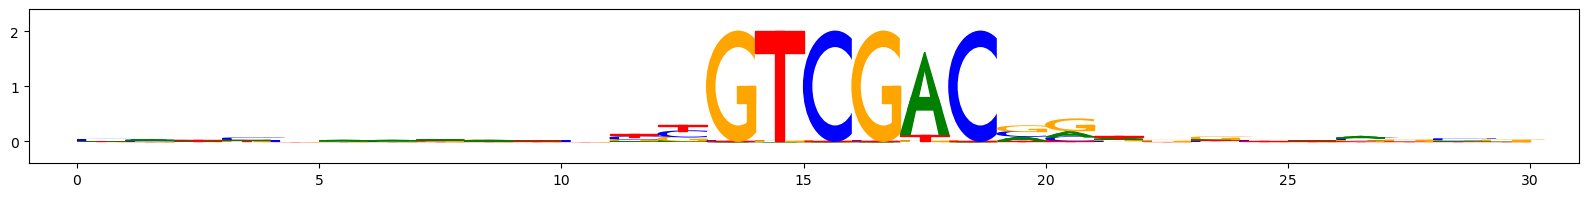

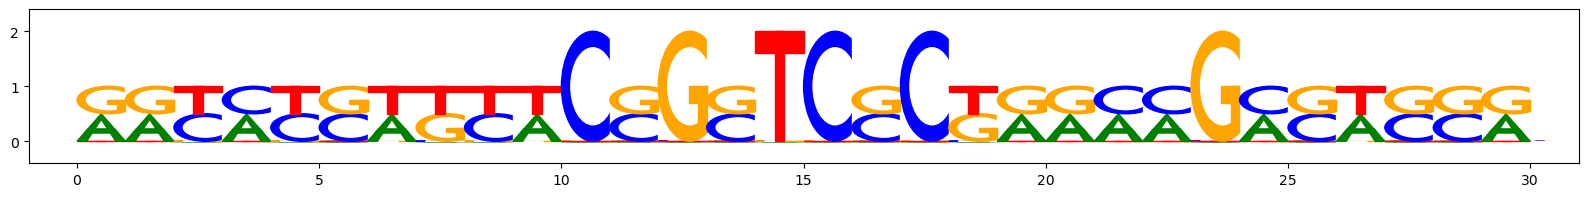

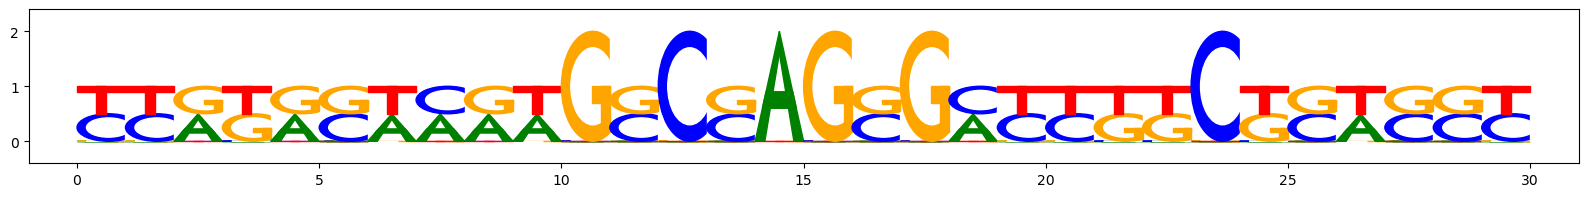

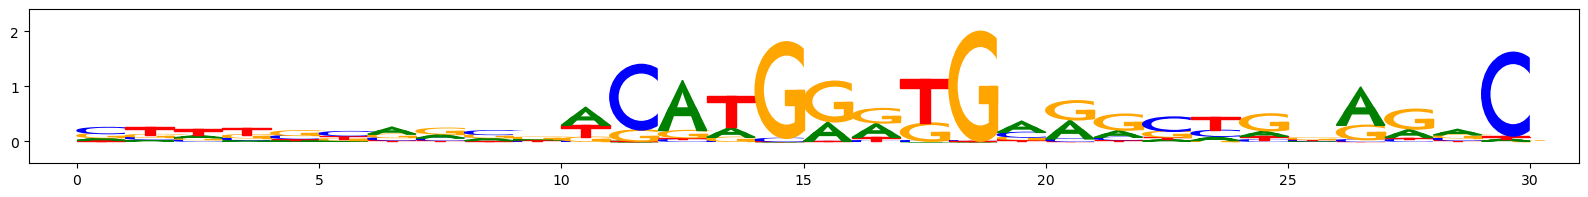

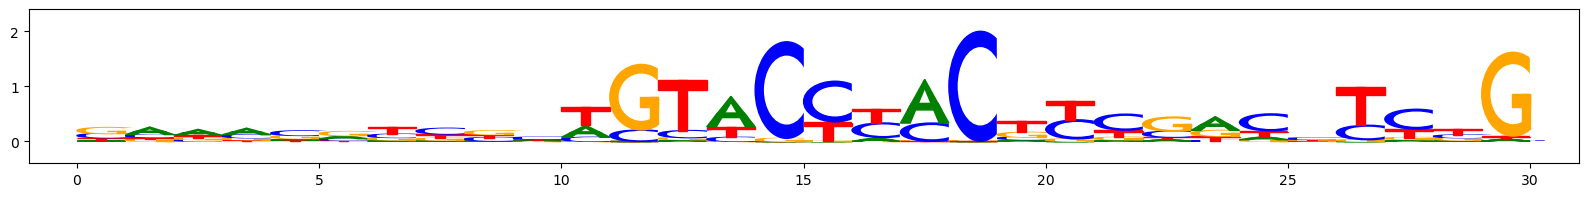

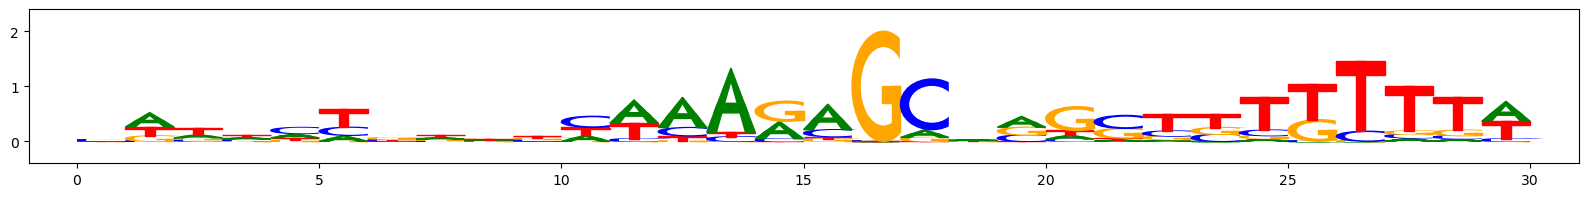

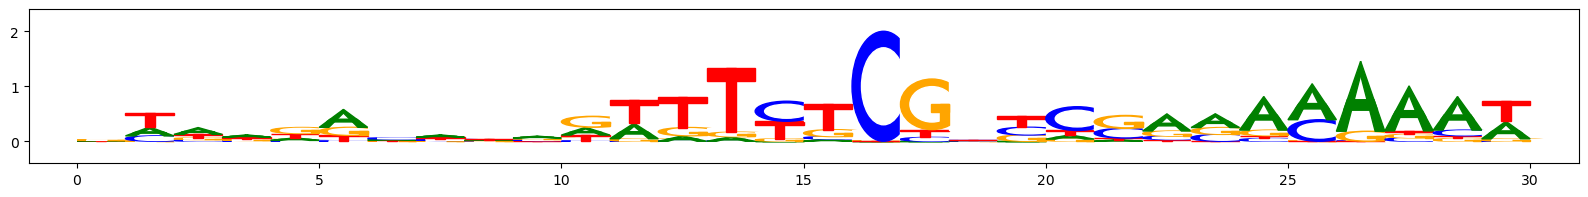

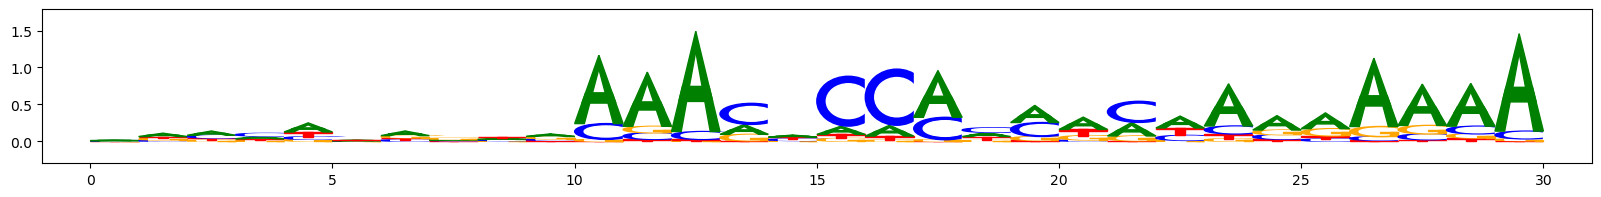

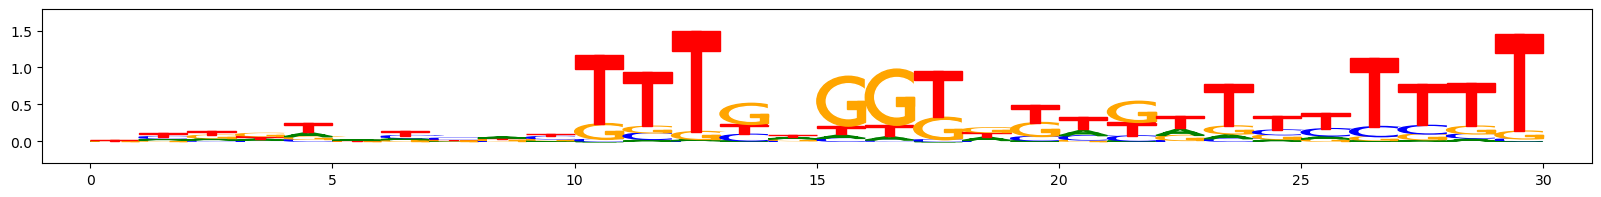

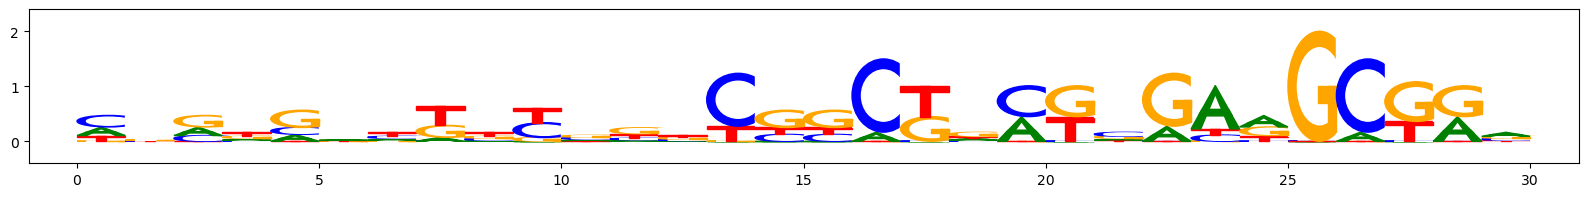

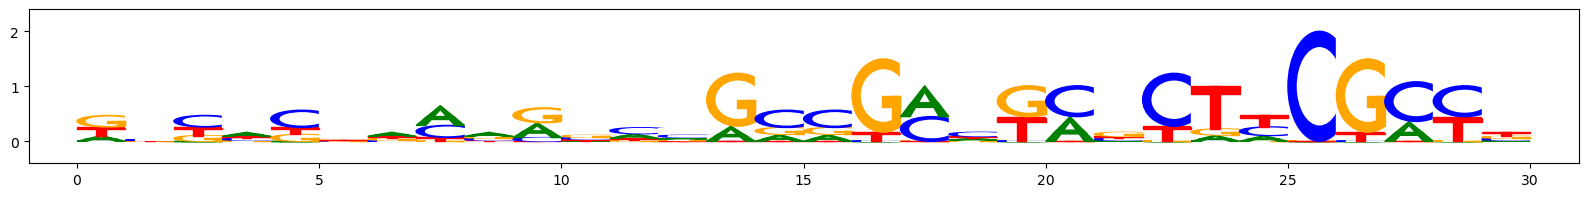

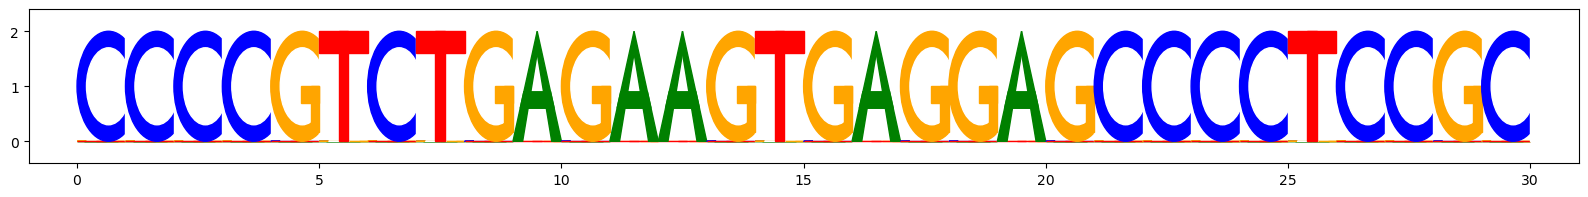

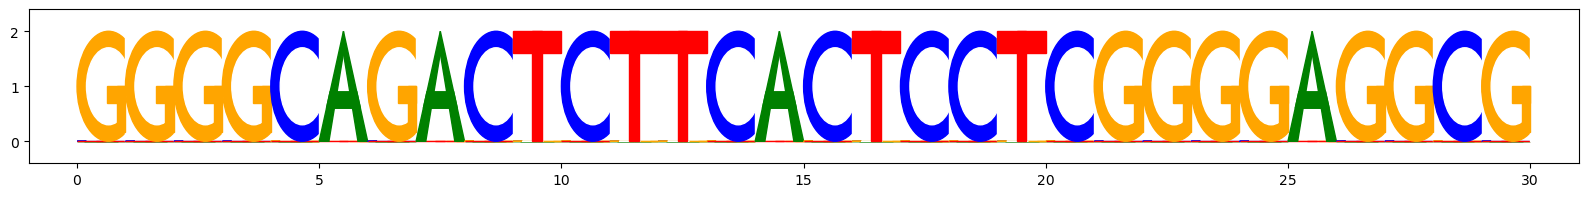

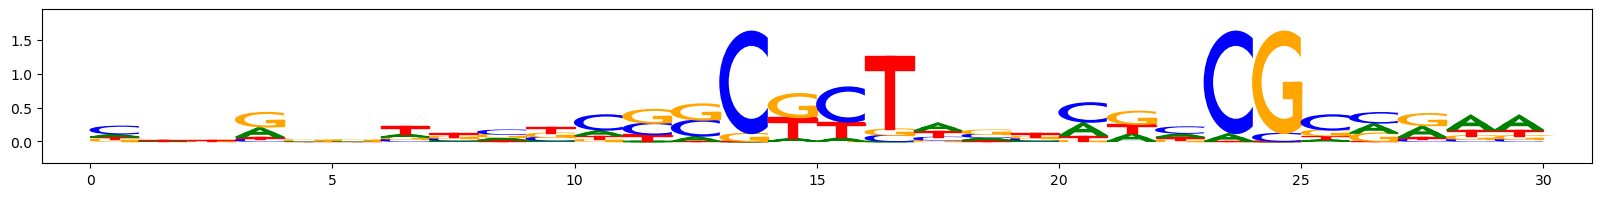

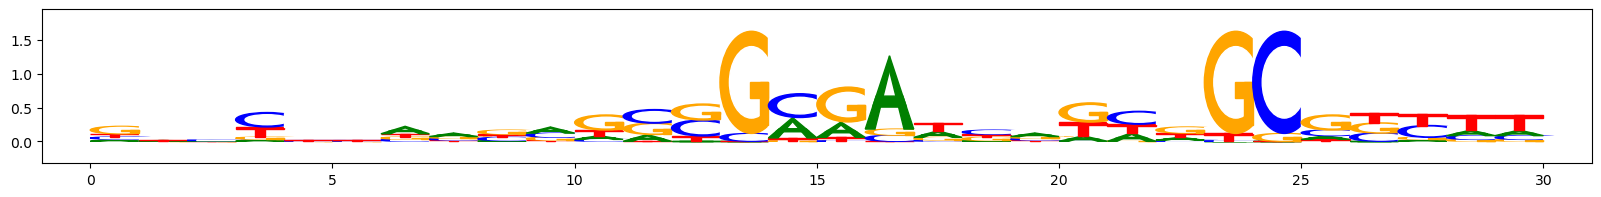

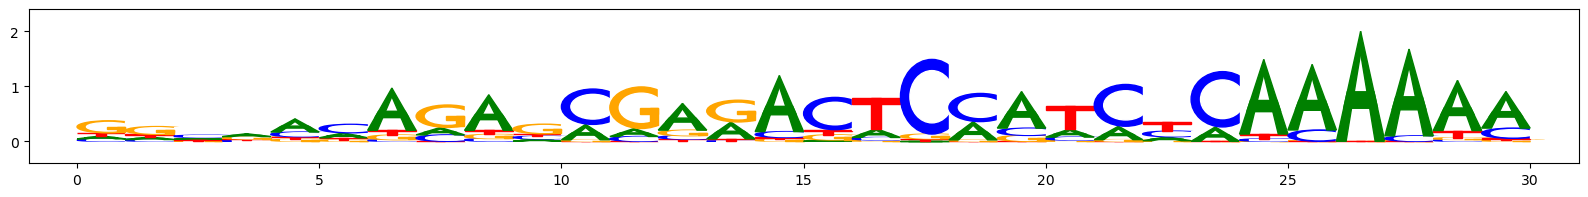

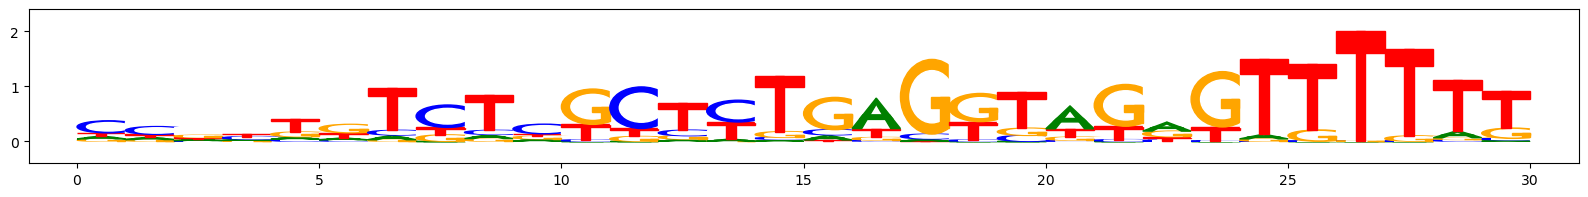

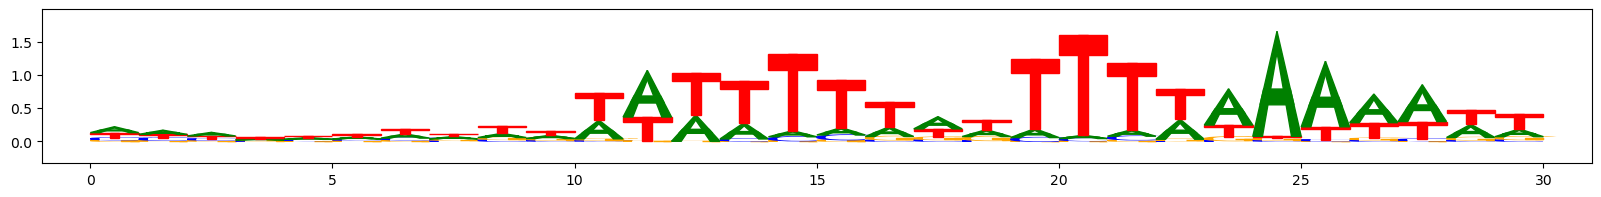

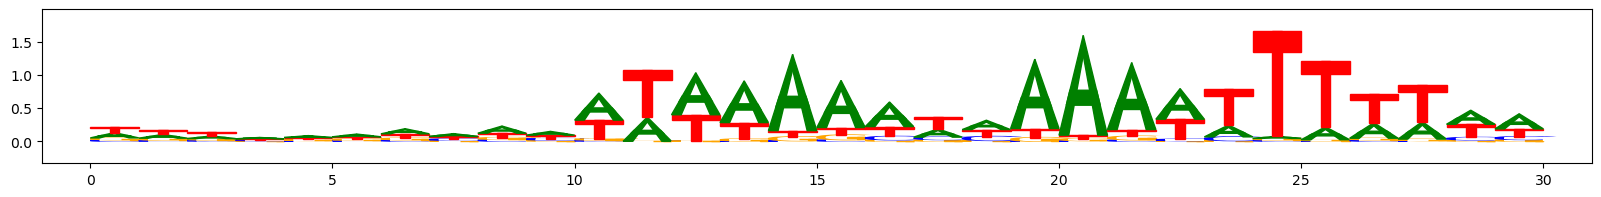

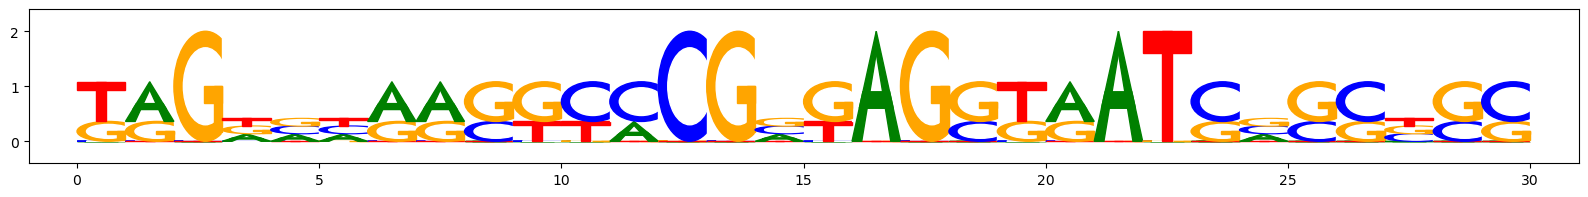

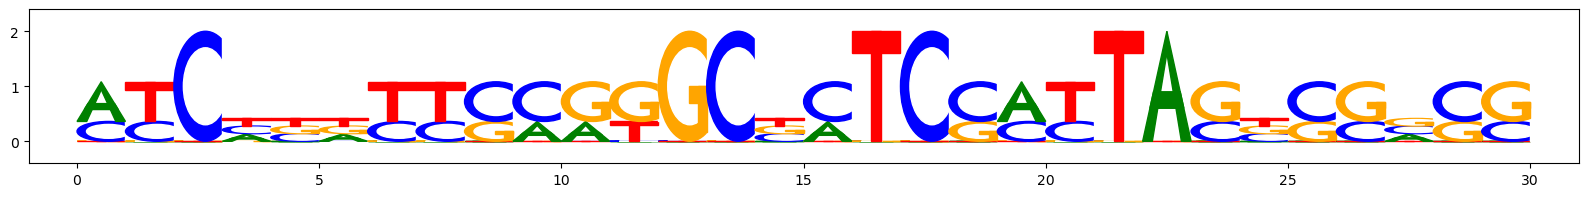

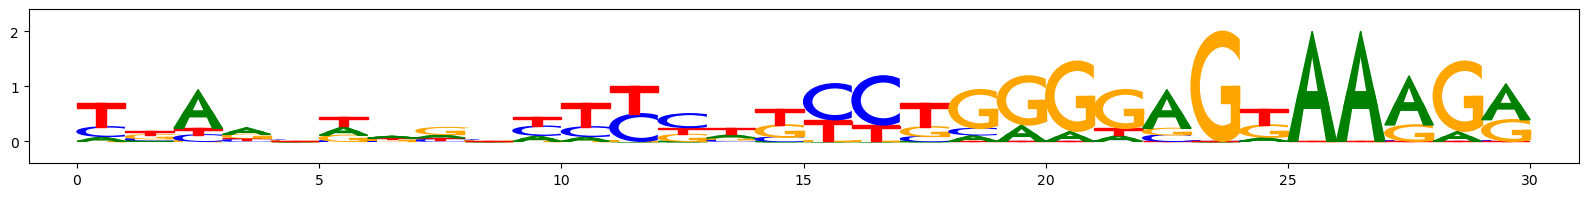

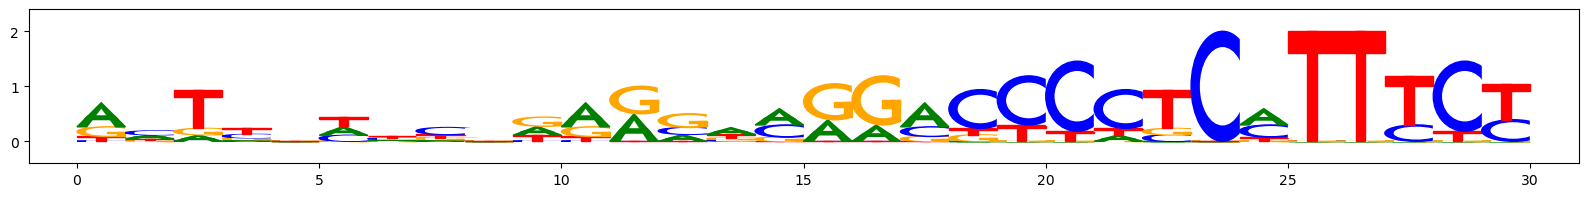

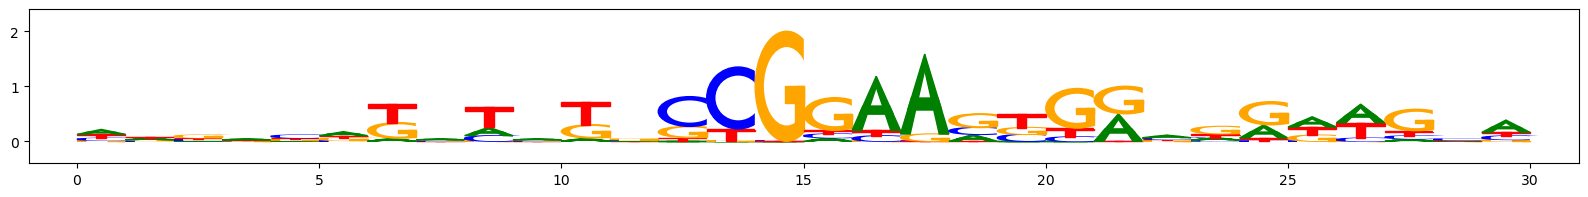

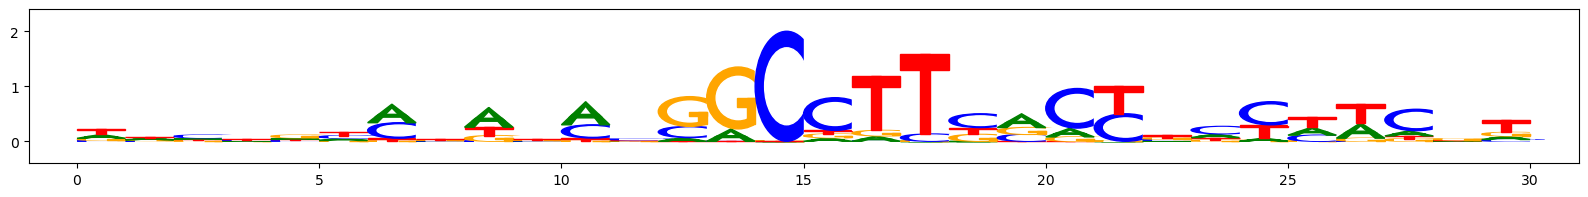

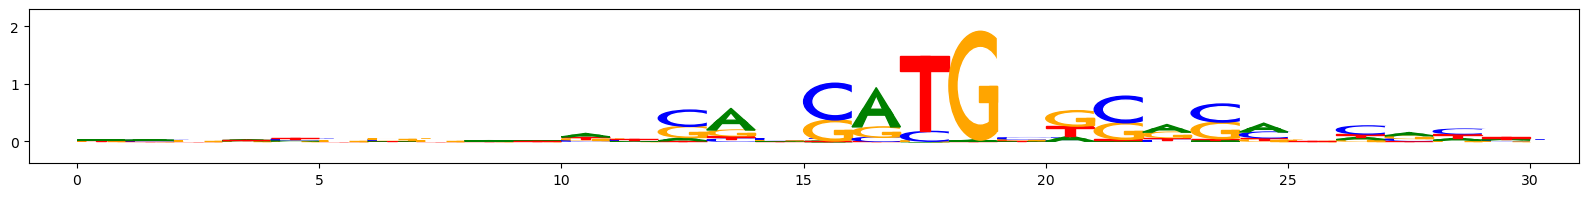

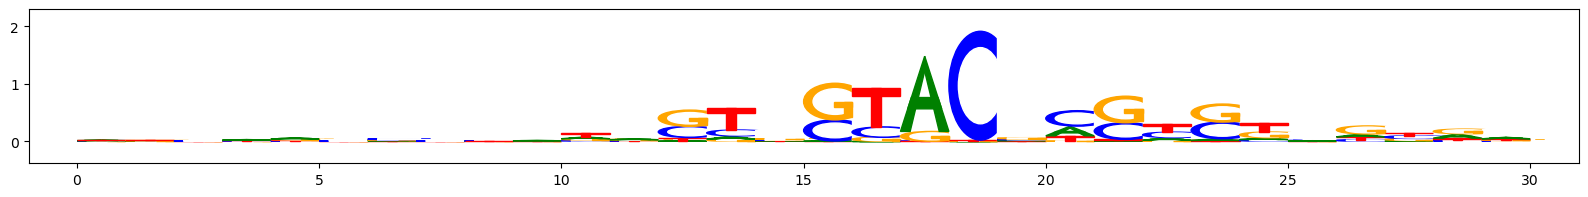

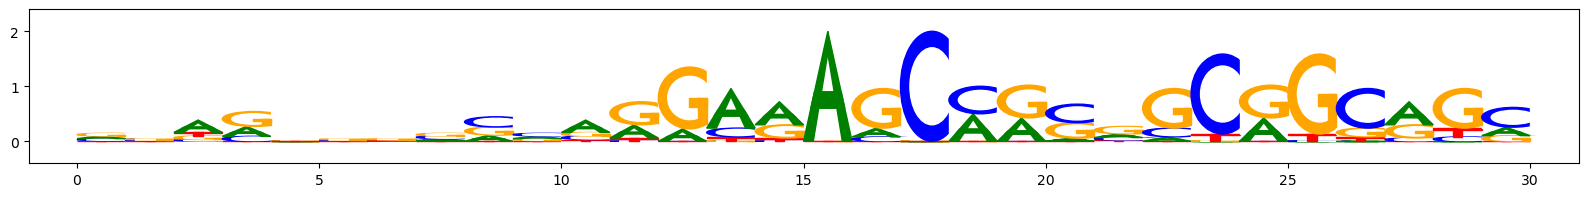

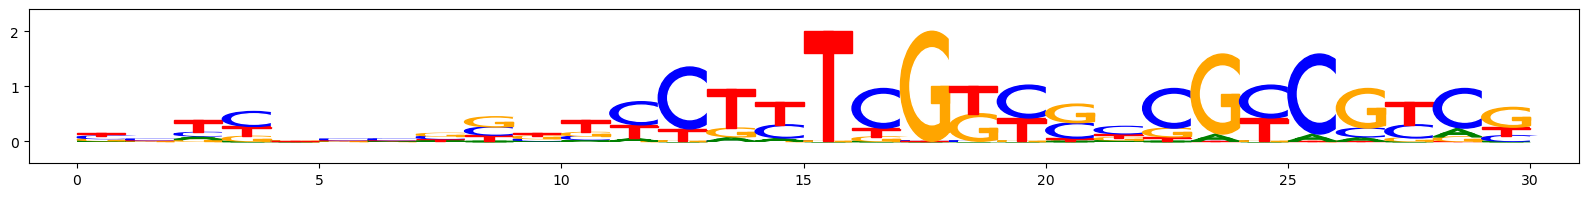

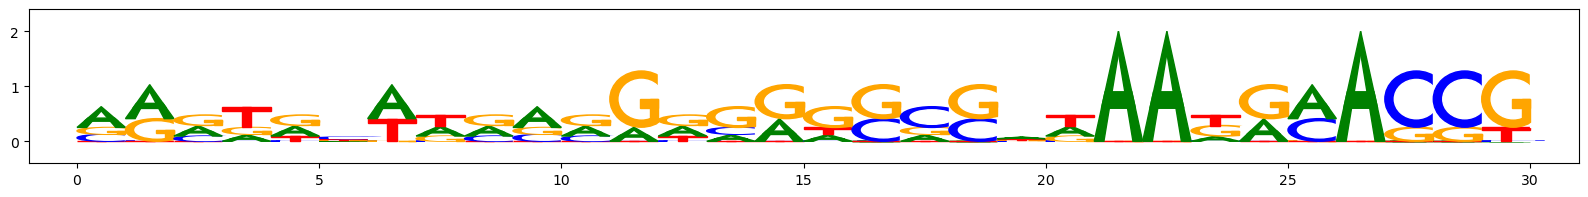

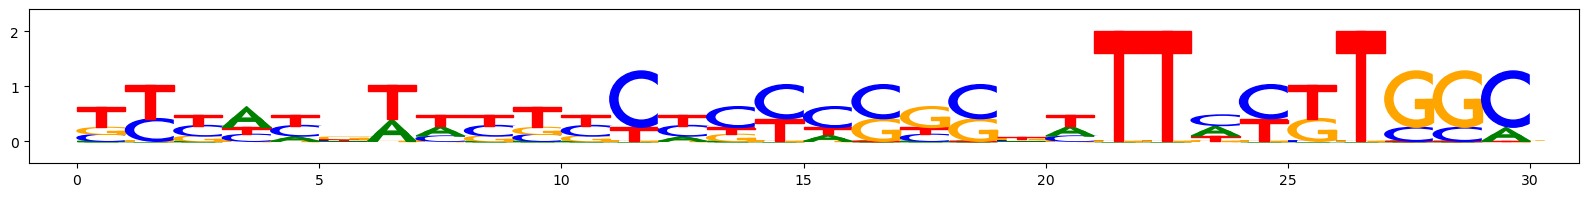

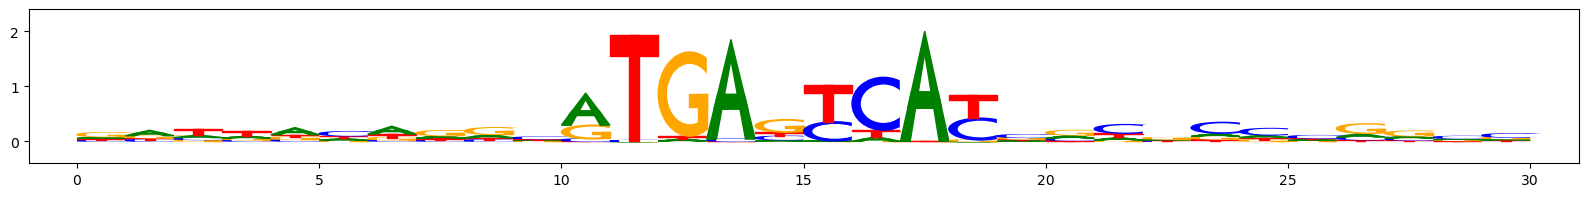

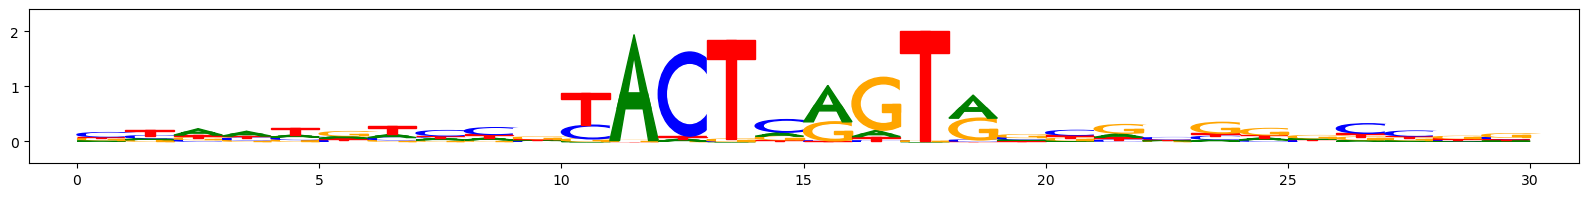

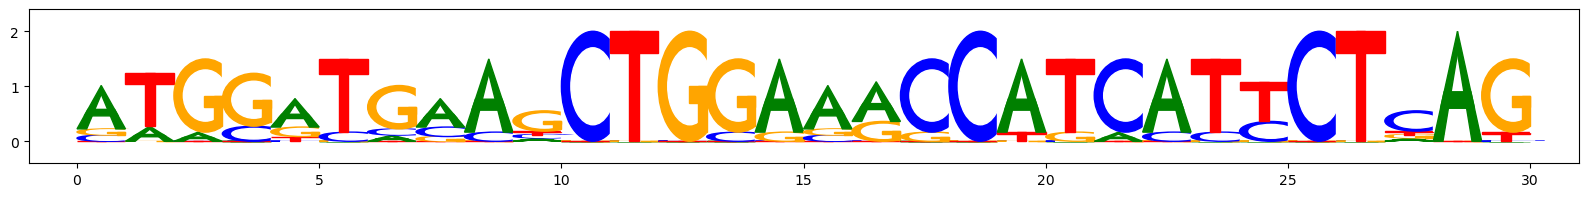

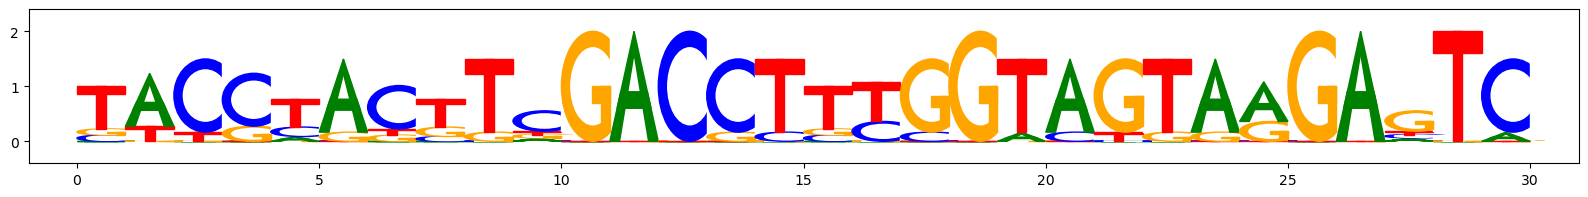

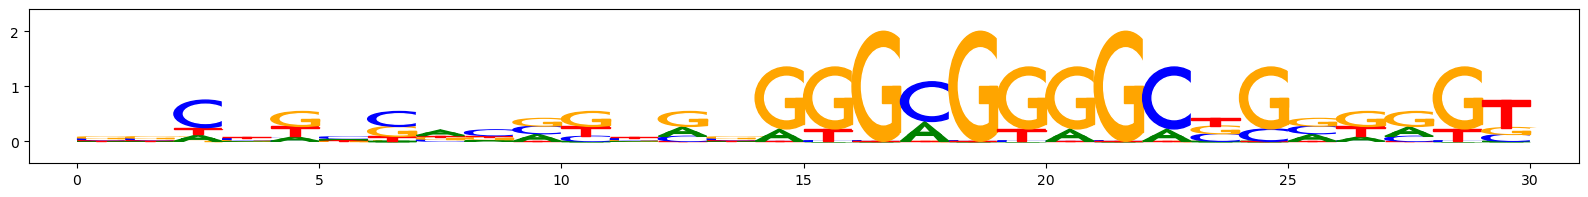

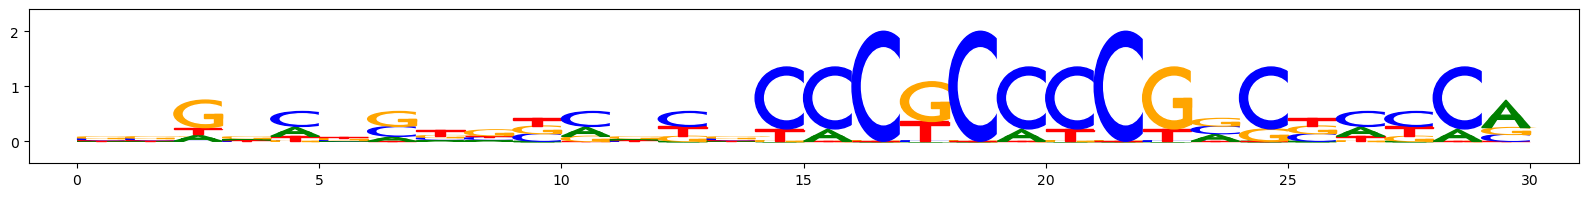

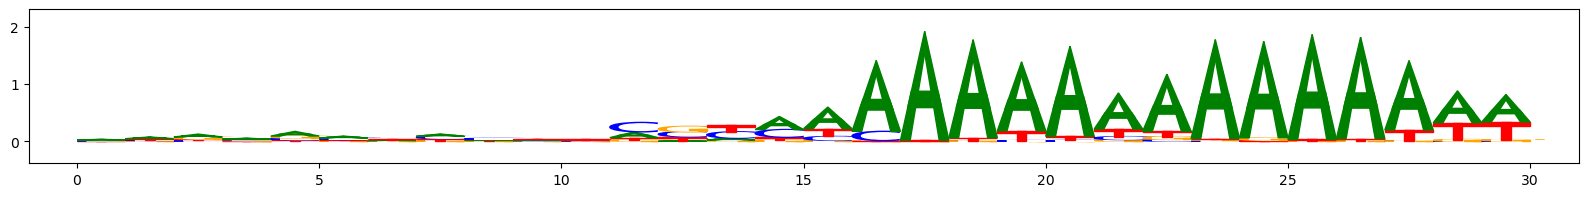

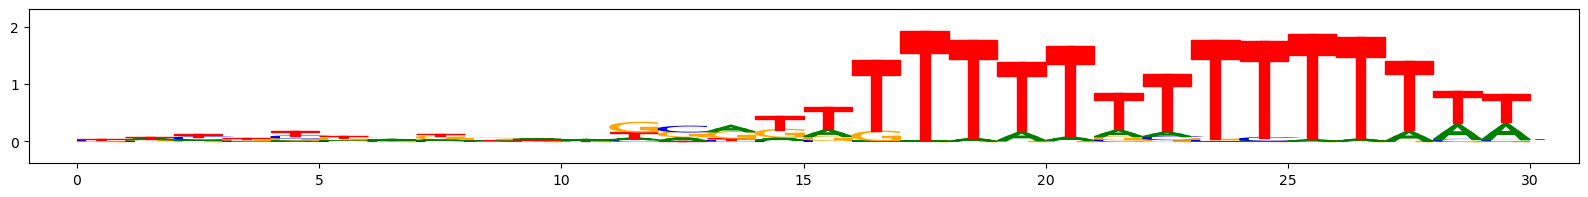

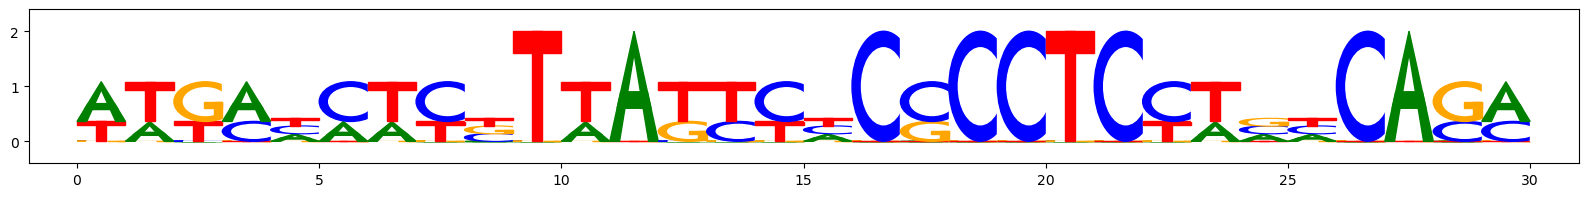

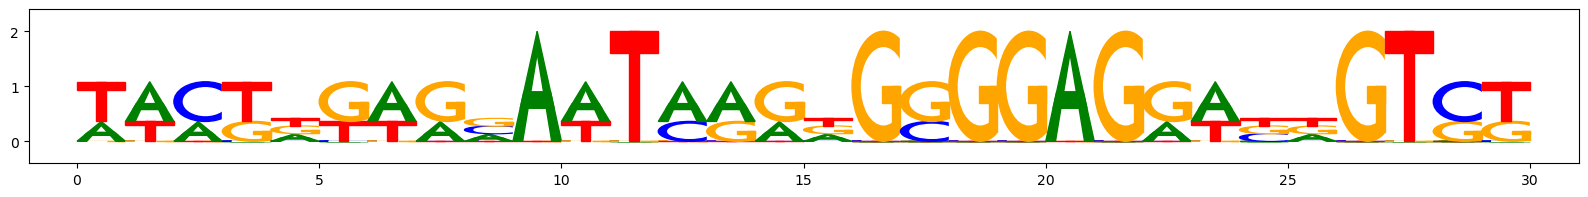

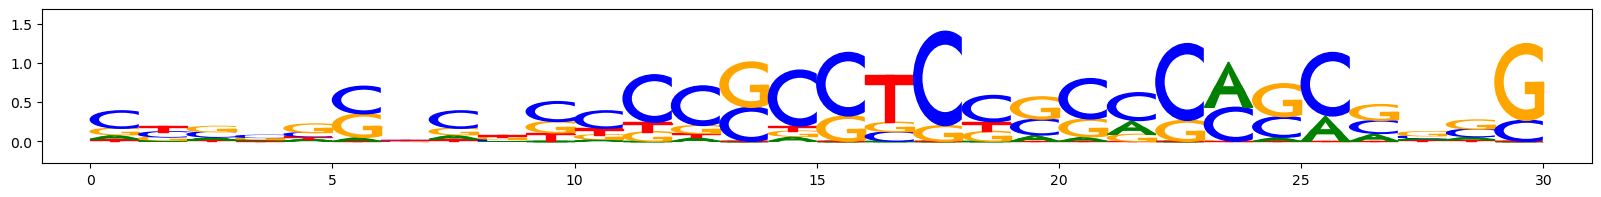

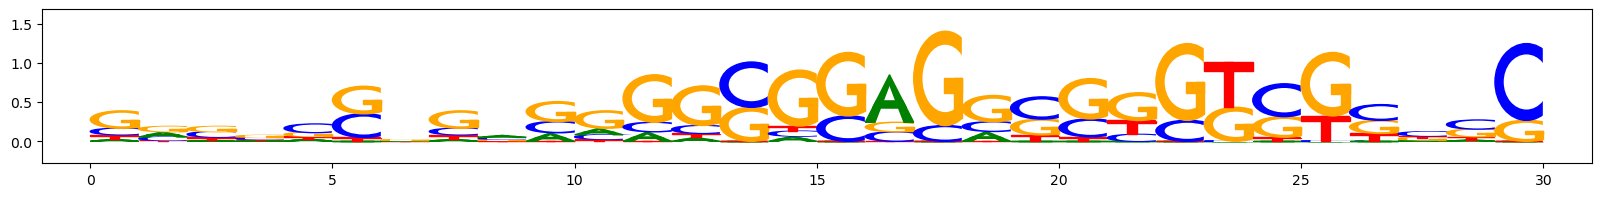

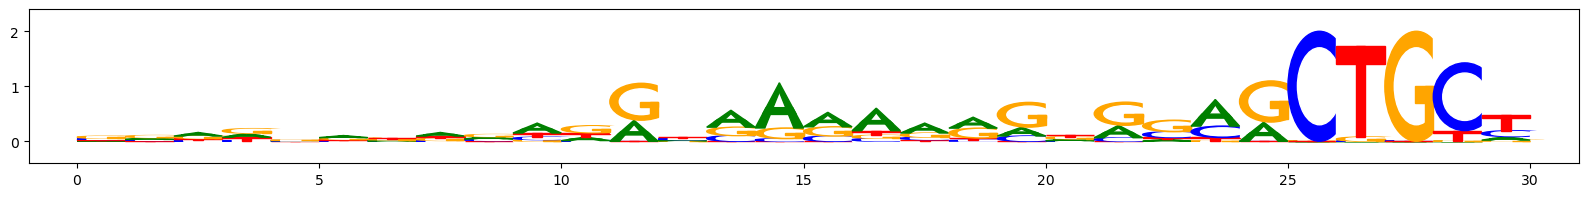

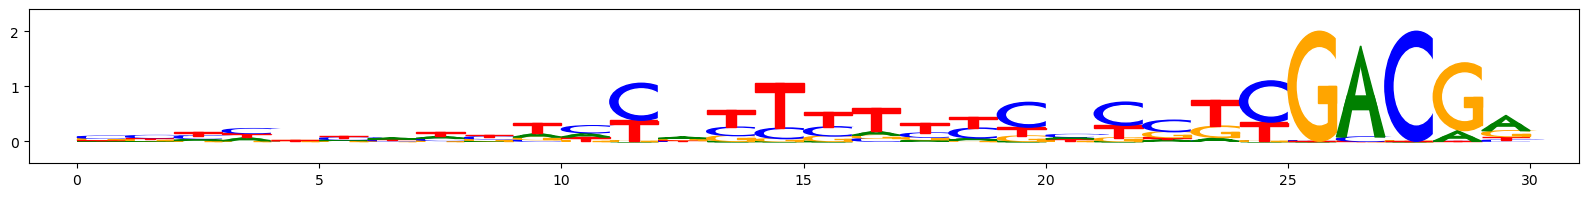

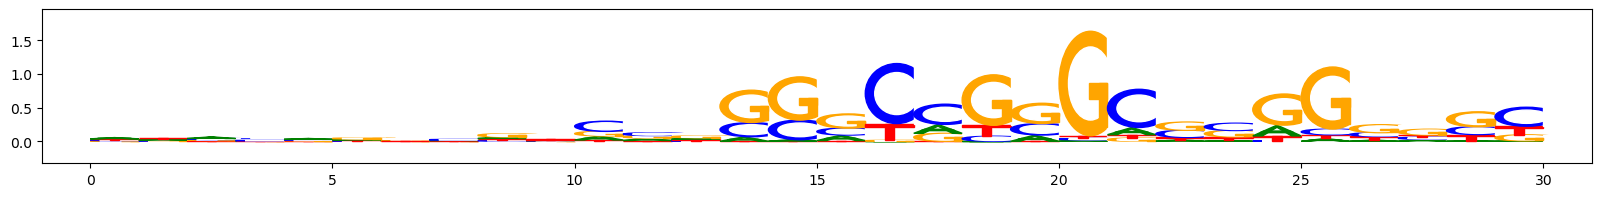

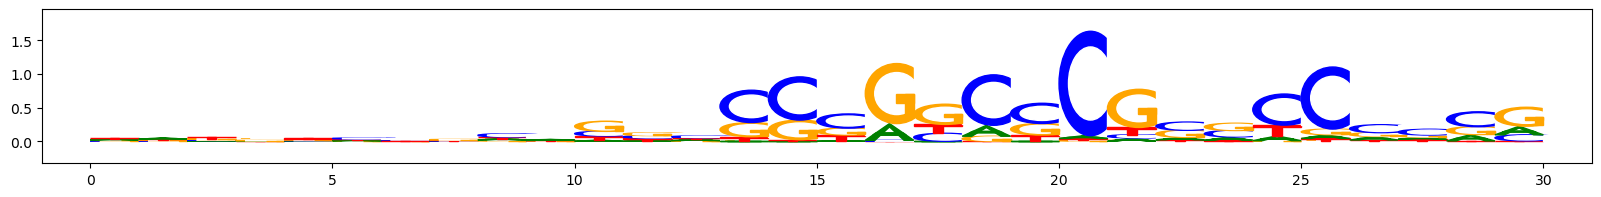

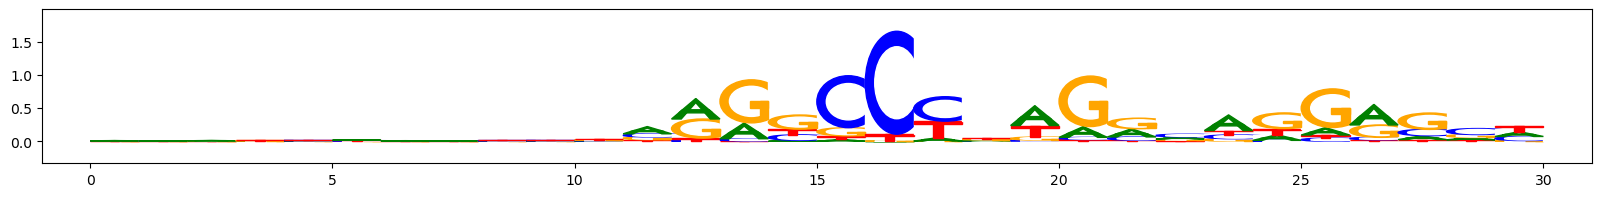

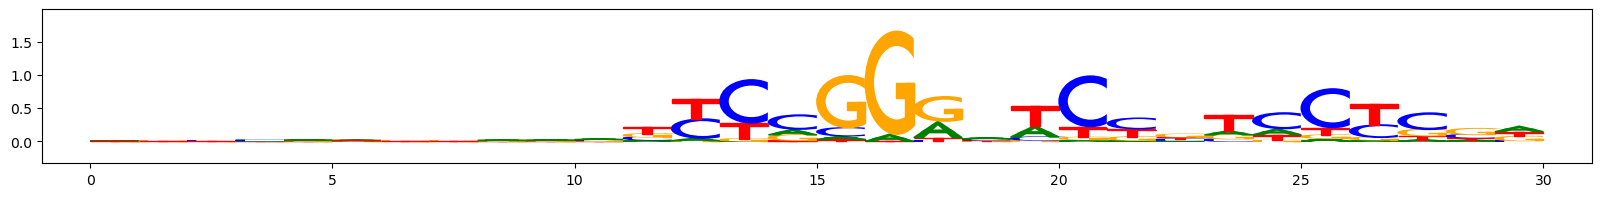

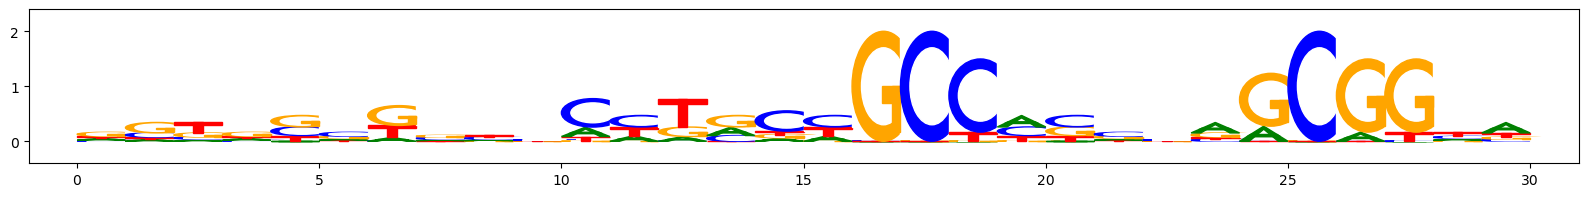

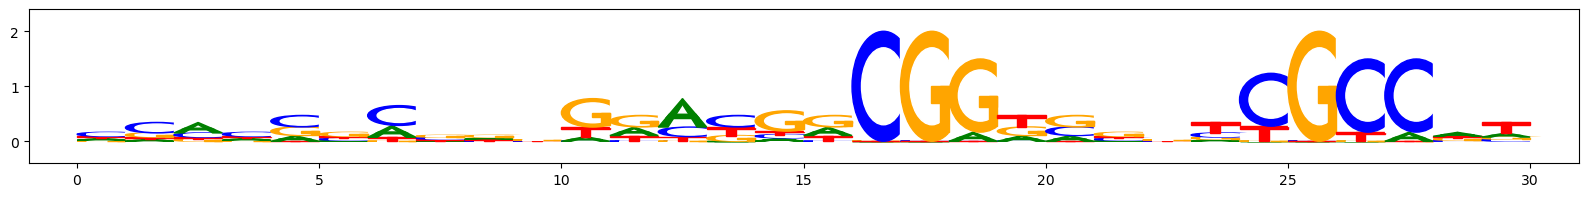

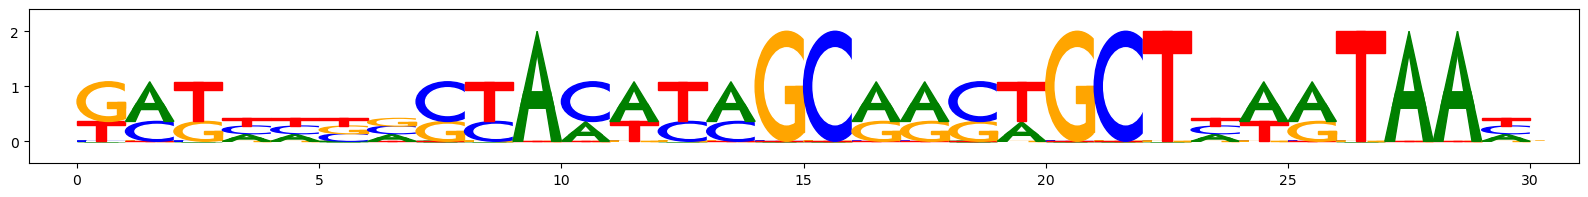

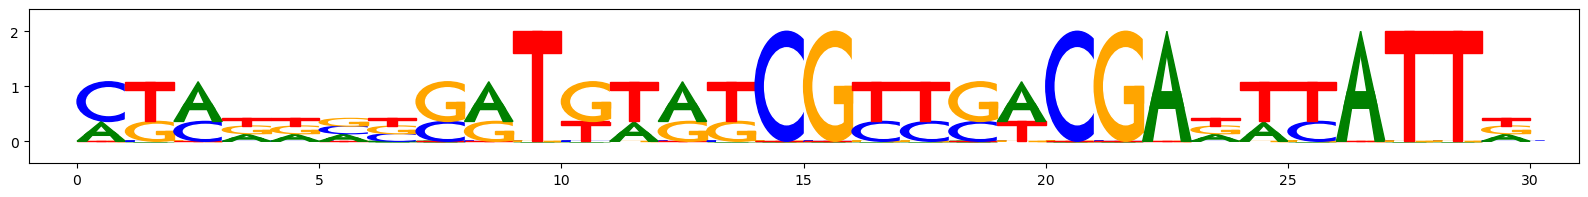

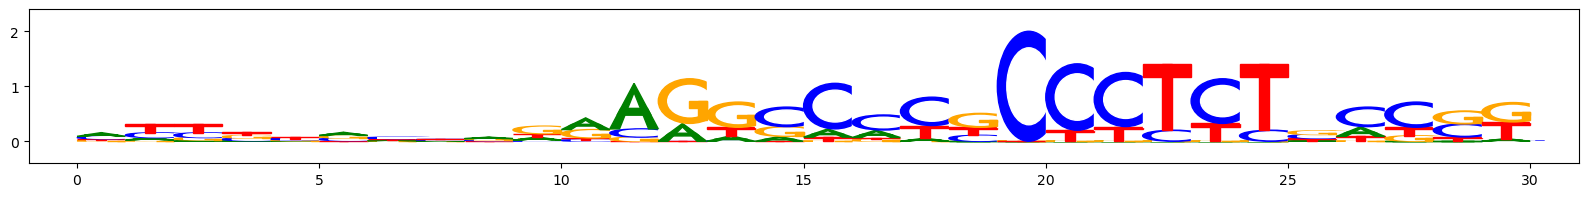

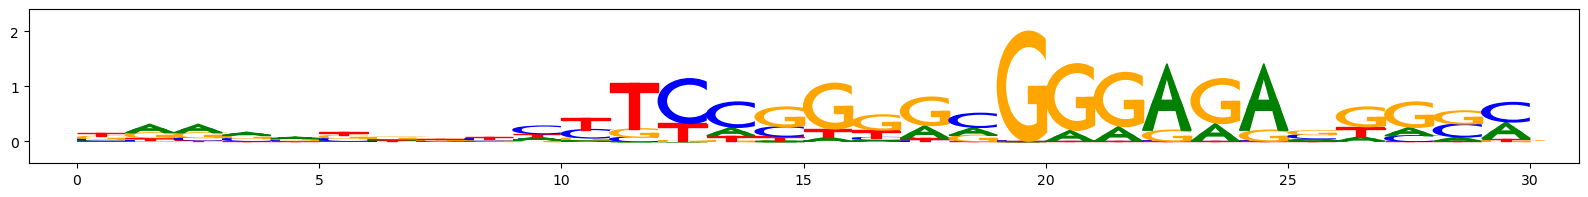

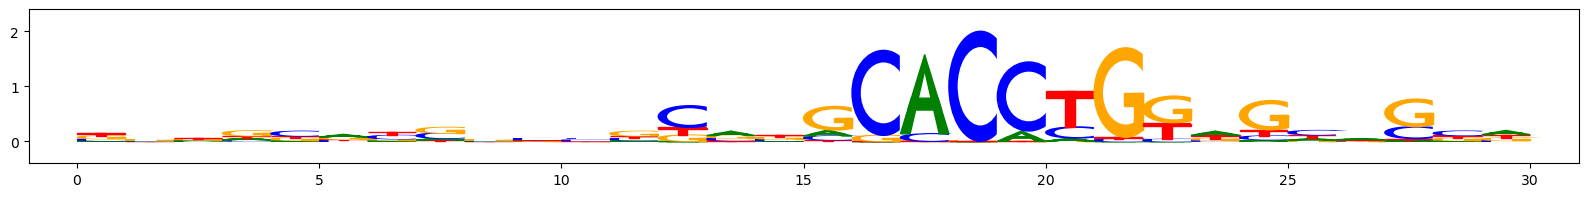

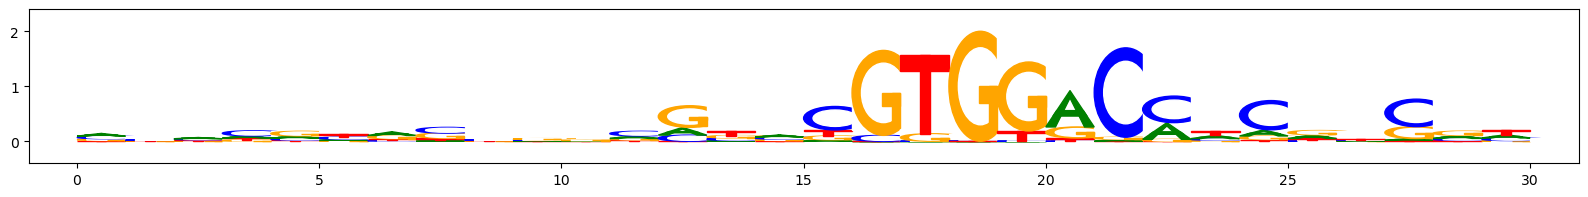

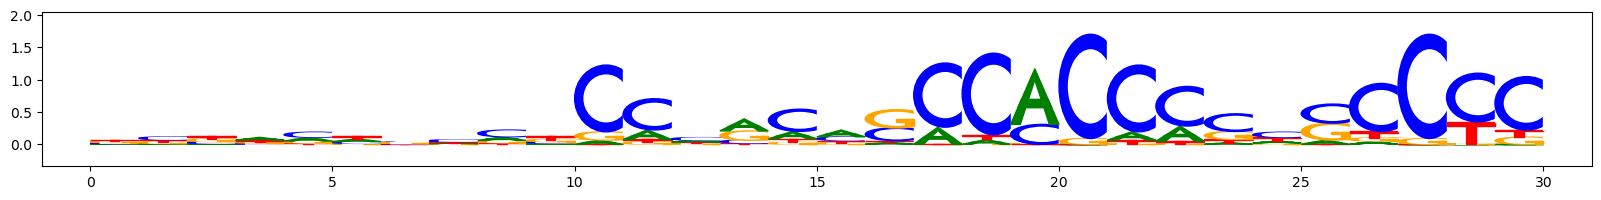

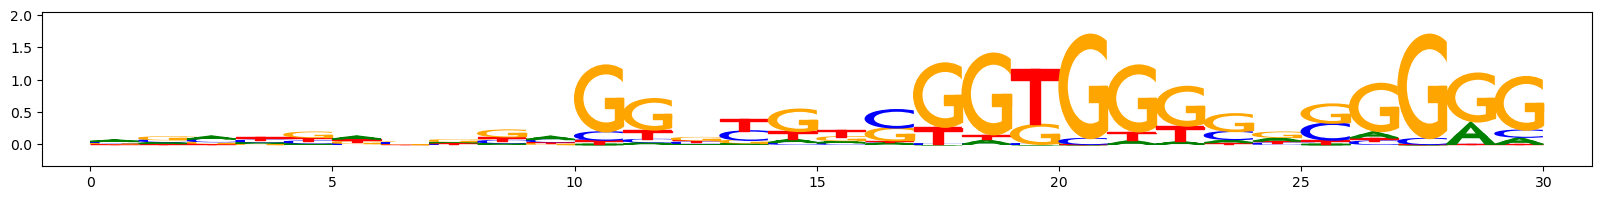

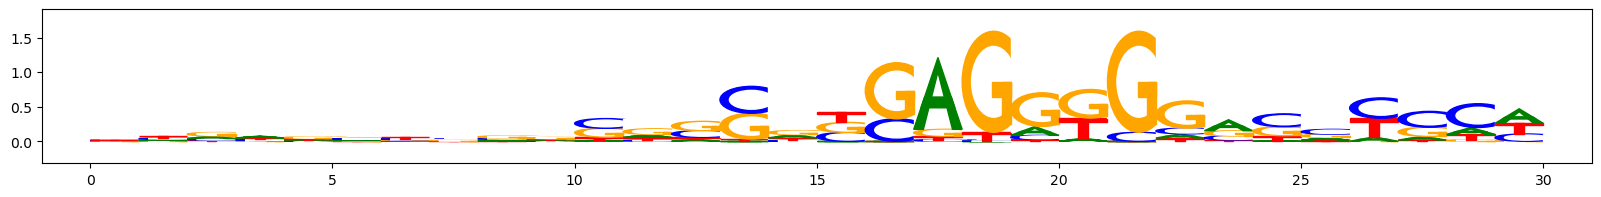

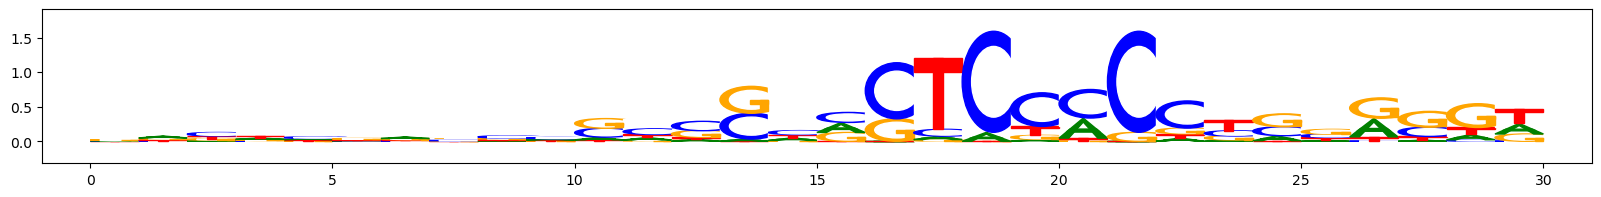

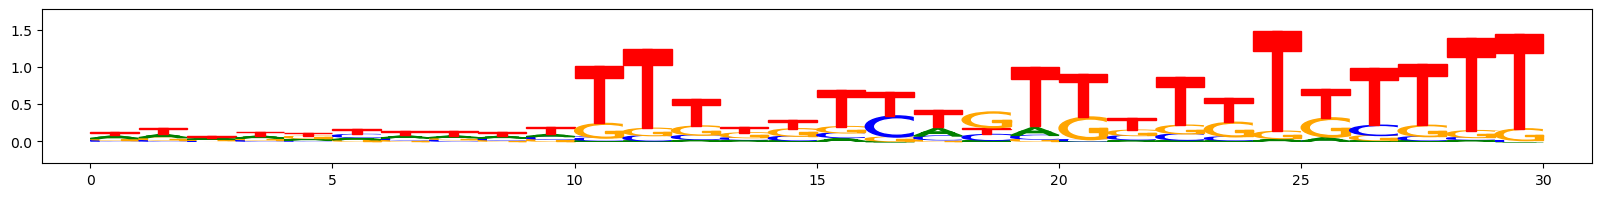

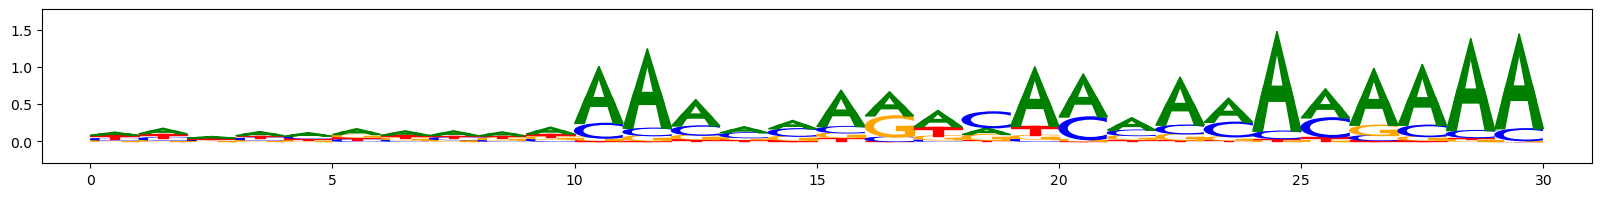

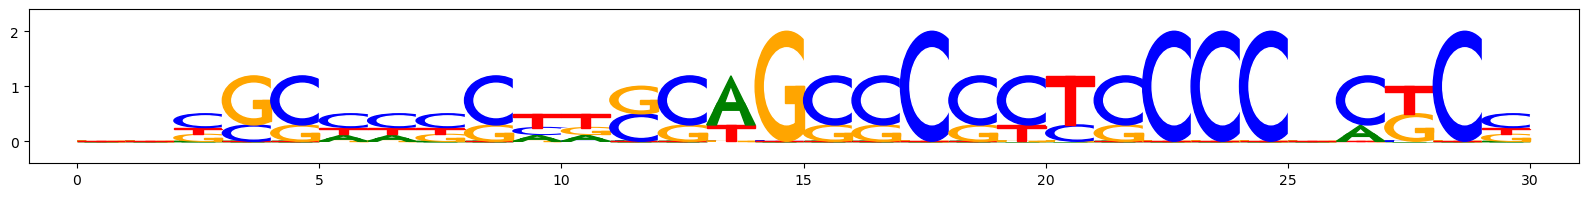

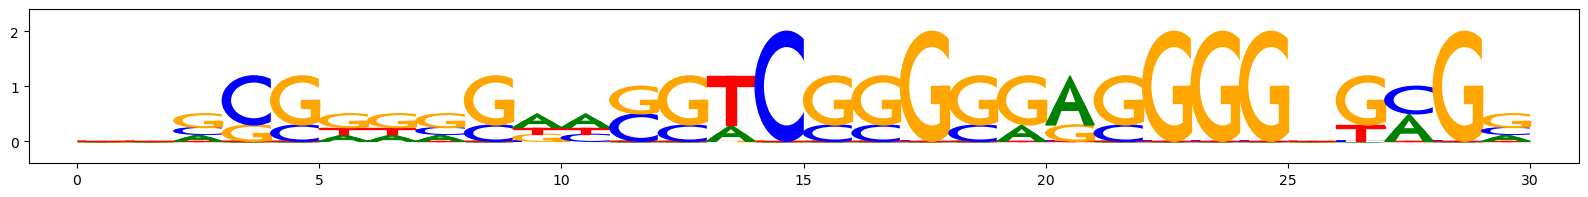

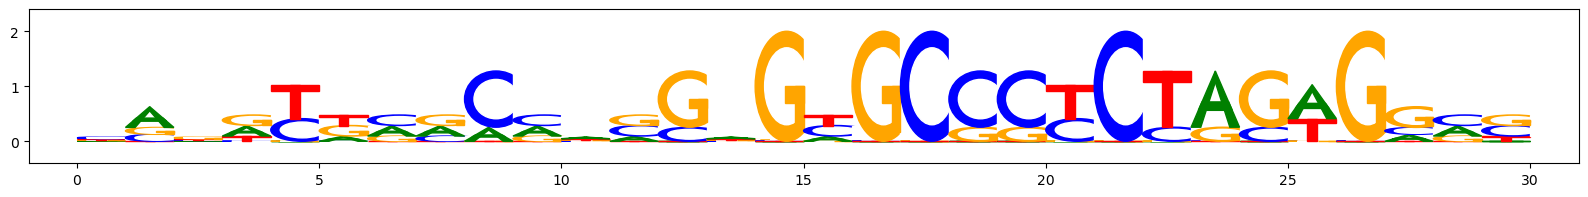

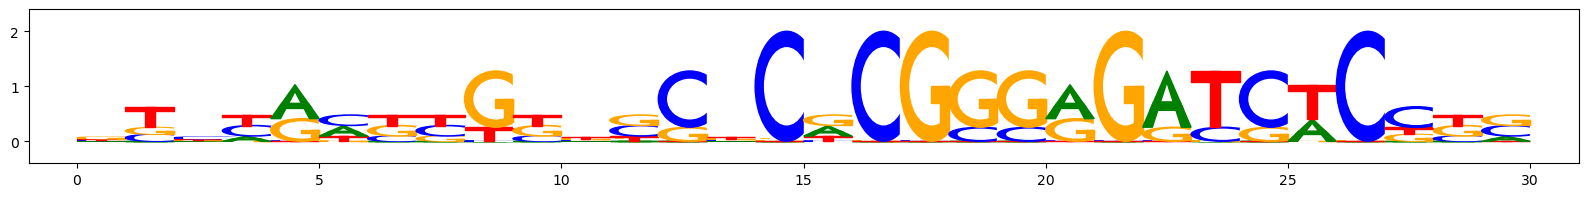

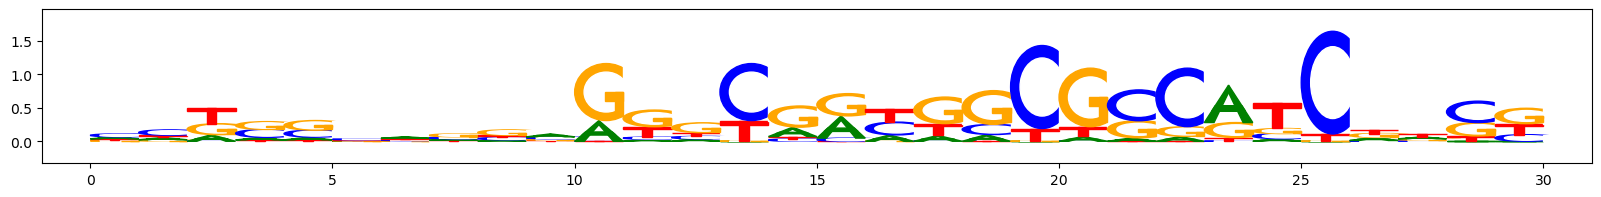

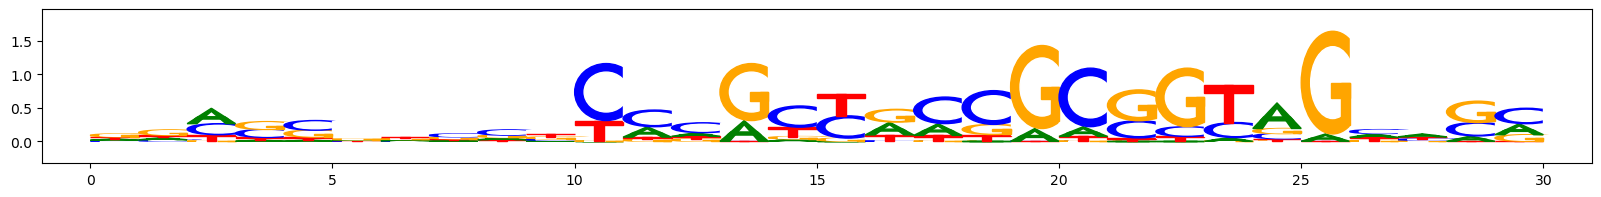

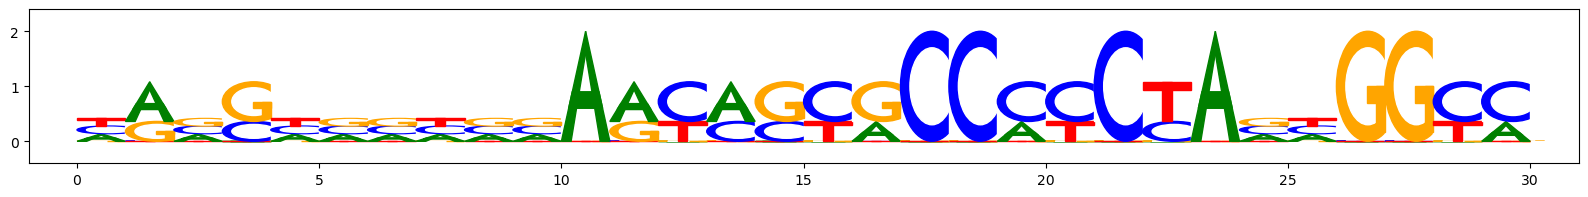

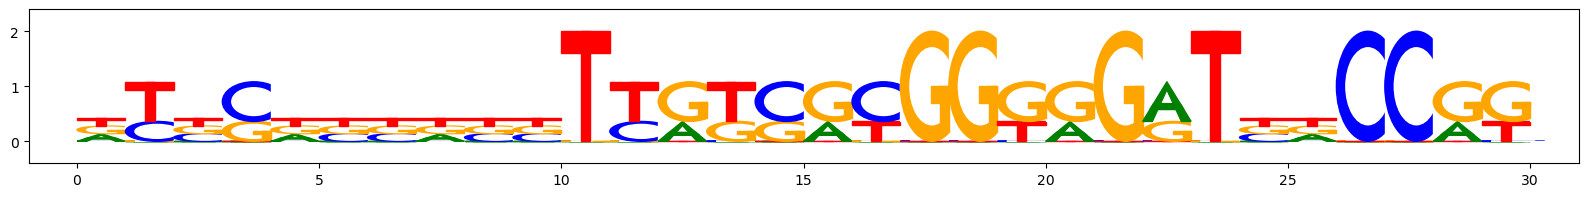

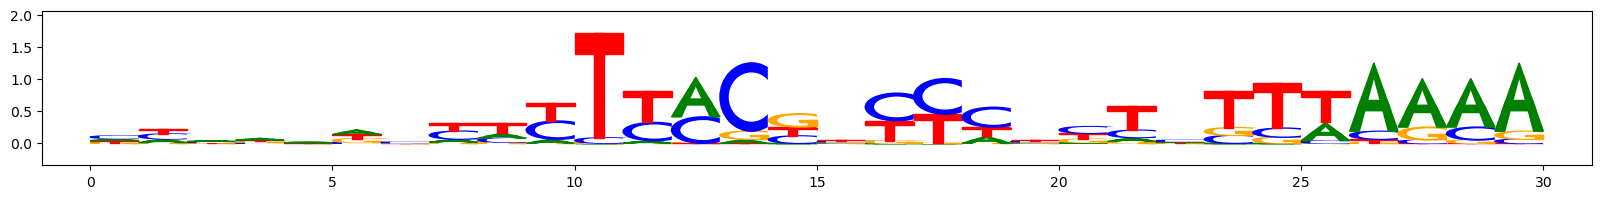

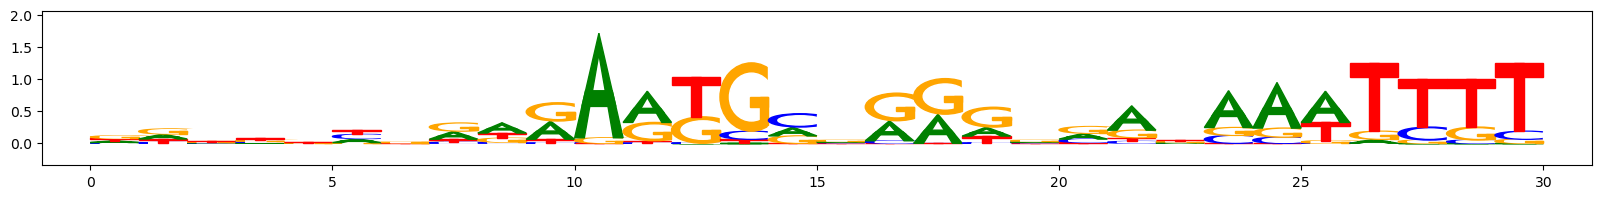

In [30]:
from deeplift.visualization import viz_sequence

nucleotides = ["A", "C", "G", "T"]

#For each filter remove sequences whose max activation is lesser than 70% of maximum activation of the filter
for i in range(first_conv.size(1)):
    max_seq = first_conv[:,i,:].max(dim=1).values
    keep_seq = max_seq > (0.7* max_activations[i])

    #Get subsequence where activation is maximal in each sequence
    if keep_seq.sum() > 0 :
        subseq = []
        for j,keep in enumerate(keep_seq):
            if keep:
                idx = first_conv[j,i,:].argmax().item()
                if (idx - 10) >= 0 and (idx+21) < len(seq):
                    subseq.append(seq[j][(idx-10):(idx+20)])
        
        if subseq:
            #Count nucleotides occurrence at each position
            count_bp = []
            for h in range(len(subseq[0])):
                count_tmp = ["".join([x[h] for x in subseq]).count(n)/len(subseq) for n in nucleotides]
                count_bp.append(count_tmp)
            
            count_bp = np.transpose(np.array(count_bp))

            #Compute information content matrices
            IC_position = [np.log2(4) + np.sum(count_bp[:,j]*np.log2(count_bp[:,j]+0.0000001)) for j in range(count_bp.shape[1])]
            count_bp *= IC_position

            #Visualize inportance at each position of nucleotides
            viz_sequence.plot_weights(count_bp, subticks_frequency=5)

            #Visulaize the reverse complement of the importance logo
            count_bp[[0,3],:] = count_bp[[3,0],:]
            count_bp[[1,2],:] = count_bp[[2,1],:]
            viz_sequence.plot_weights(count_bp, subticks_frequency=5)
